说明：  
本文档使用的数据来自于 Data clean 1 里 的填充过缺失值的数据。

<font face="微软雅黑" size=5> Contents： </font>  
1. 准备数据集  
2. 过拟合XGB模型  
3. GridSearchCV进行超参数交叉验证  
&ensp;&ensp;&ensp;&ensp;3.1 自定义网络搜索函数  
4. 交叉验证  
5. 训练最终XGB模型并预测未知样本集  
6. 提交结果


In [1]:
import numpy as np
import pandas as pd
import time
# from scipy import special
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.pipeline import make_pipeline

from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,rand
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import time
from sklearn.externals import joblib
import pickle
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# 准备数据集

In [2]:
# 读取数据集 data1，记为 data

data = pd.read_csv(r'F:\RiskPre2\Data clean 1\data1.csv').set_index("userID")

In [3]:
data.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.000000,0.000000,18.767298,18.767298,0.000000,0.000000,3.000000,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,1.059802,0.053767,28.728905,16.445445,8.294372,3.533376,1.000000,20.664418,5914855887,0.0


In [4]:
# 从数据集 data中提取出训练集和未知样本集
# 训练集 data_tr，(55381, 425)。未知样本集 data_te，(13899, 425)

userIDtrain = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtrain.csv').values.flatten()
userIDtest = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv').values.flatten()
data_tr = data.loc[userIDtrain,:]
print("shape of data_tr is:",data_tr.shape )
data_te = data.loc[userIDtest,:]
print("shape of data_te is:",data_te.shape )

shape of data_tr is: (55381, 425)
shape of data_te is: (13899, 425)


In [5]:
# 本来可以直接通过 data_tr， data_te 得到 以下数据集的，但是我采用 从 ModelLR 存储的对象中提取。

with open(r'F:\RiskPre2\result\data_fill_XY.pkl', 'rb') as f1:  # fill指填充过了缺失值。
    X_tr = pickle.load(f1)
    y_tr = pickle.load(f1)
    X_te = pickle.load(f1)
    y_te = pickle.load(f1)

print("shape of X_tr is:",X_tr.shape)
print("shape of y_tr is:",y_tr.shape)
print("shape of X_te is:",X_te.shape)
print("shape of y_te is:",y_te.shape) 

shape of X_tr is: (55381, 424)
shape of y_tr is: (55381,)
shape of X_te is: (13899, 424)
shape of y_te is: (13899,)


In [6]:
X_tr.head(3)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__available_balance_max,bill_AL_cardM__available_balance_median,bill_AL_cardM__available_balance_min,bill_AL_cardM__borrow_cash_sum,bill_AL_cardM__borrow_cash_max,bill_AL_cardM__borrow_cash_median,bill_AL_cardM__borrow_cash_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,1.025837,0.644378,0.049019,25.766646,14.131988,11.047256,5.839872,2.897174,44.916014,5914855887
2,0,1,0,0,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,20.376736,20.376736,0.000000,0.000000,3.000000,61.523250,5914855887
3,0,1,0,0,0,0,0,1,0,0,...,1.326071,0.139983,0.087685,19.800723,13.605240,8.804037,4.214494,1.000000,18.361833,5914855887


In [7]:
y_tr.head(2)

userID
1    0.0
2    0.0
Name: target, dtype: float64

In [8]:
# 本来可以直接通过 对 X_tr，y_tr 进行二八分 得到 以下数据集的，但是我采用 从 ModelLR 存储的对象中提取。
# 因为 train_test_split 里有随机过程，为了保证此处的二八分与 ModelLR 里的相同，所以采用提取的方式。

with open(r'F:\RiskPre2\result\split2_8.pkl', 'rb') as f2:  # fill指填充过了缺失值。
    X_tr_train = pickle.load(f2)
    y_tr_train = pickle.load(f2)
    X_tr_test = pickle.load(f2)
    y_tr_test = pickle.load(f2)

print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)
scale_pos_weight_value=len(y_tr_train[y_tr_train==0])/len(y_tr_train[y_tr_train==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_train is:",scale_pos_weight_value)
scale_pos_weight_value1=len(y_tr_test[y_tr_test==0])/len(y_tr_test[y_tr_test==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_test is:",scale_pos_weight_value1)
# 可见，二八分得的训练集和验证集里的 正负样本比例基本相同，即实现了 stratify.

shape of X_tr_train is: (44304, 424)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 424)
shape of y_tr_test is: (11077,)
negative number/positive number in y_tr_train is: 6.7441006816990035
negative number/positive number in y_tr_test is: 6.746153846153846


# 过拟合XGB模型

&ensp;&ensp;调参主要是调过拟合。我觉得可以先尝试最过拟合的可能性，比如树最深等等，看看对训练集和对验证集的auc相差多少。如果训练集的auc很高，验证集的auc很低，说明过拟合。这时可以逐步把与抑制过拟合相关的参数进行调整，使得出现：训练集auc降低，验证集auc提高的效果。   
&ensp;&ensp;这里，对整个训练集X_tr_train，y_tr_train的五折进行学习，学得5个模型，每个模型对自己的训练集和验证集进行预测并算auc，猜测应该训练集的auc很高（过拟合），而测试集的auc很低。

In [9]:
# 对训练集X_tr_train，y_tr_train进行一次性五折划分（此划分和 ModelLR 里的不同）。
# Xt 存储了 5个二维array，分别是5份训练集。  
# Xv 存储了 5个二维array，分别是对应的5份验证集。
# Yt 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yv 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=8)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xt = []
Yt = []
Xv = []
Yv = []
for train_index, validation_index in skf.split(X_tr_train.values,y_tr_train.values):  
    Xt.append(X_tr_train.values[train_index])
    Yt.append(y_tr_train.values[train_index])
    Xv.append(X_tr_train.values[validation_index])
    Yv.append(y_tr_train.values[validation_index])

In [10]:
# 设置 XGB 参数 使过拟合

XGB_param1 =dict(
    max_depth=10,                       # 树的最大深度
    learning_rate=0.5,                  # 提升树的学习率                     
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,             # 此为默认设置，打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    gamma=0,                            # （默认）设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    max_delta_step = 0,                 # （默认）此为默认设置，每棵树权重改变的最大步长。
    subsample=1,                        # （默认）训练每棵树时实例数据随机采样的比例
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    colsample_bylevel = 1,              # （默认）此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda =0,                      # （默认）此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,                   # （默认）此为默认设置，
    seed = 9,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。不过我的数据无缺失。      
    )


In [11]:
# 对训练集的五折划分，每一折都训练一个XGB模型，每个模型分别对自己的训练集和验证集进行预测并计算 auc。
# Models1 保存了 5 个模型。 Scores1 保存了 5 个模型分别对各自的验证集进行预测算得的 auc。
# 并求 5 个验证集 auc 值 的均值。

modelXGB1 = XGBClassifier(**XGB_param1)
timestart = time.time()
Scores1=[]
Models1=[XGBClassifier(**XGB_param1) for i in range(len(Xt))]  # 创建 5 个模型
for i in range(len(Xt)):
    Models1[i].fit(Xt[i],Yt[i], eval_set = [(Xt[i],Yt[i]),( Xv[i],Yv[i])],
                   eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
    Scores1.append(Models1[i].best_score)
    print("-------------------------------")
print("Time: {:.2f} seconds".format(time.time() - timestart))
print("Scores1 : ", Scores1)
print("The mean auc is :", np.mean(Scores1))

# 代码技巧：我之前是这样做的：Models1=[]，然后在for循环里 modelXGB1.fit数据集，再 Models1.append(modelXGB1)
# 但发现这样做，得到的 Models1 里的五个模型全相同，都是最终的模型。所以我认为，应该在每一轮创建新的模型，
# 而不是同一个模型 modelXGB1 反复 fit 不同的数据。所以上述代码是在每一轮创建新模型。

[0]	validation_0-logloss:0.548032	validation_0-auc:0.856044	validation_1-logloss:0.590395	validation_1-auc:0.694288
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.481939	validation_0-auc:0.888788	validation_1-logloss:0.555748	validation_1-auc:0.72201
[2]	validation_0-logloss:0.42501	validation_0-auc:0.918021	validation_1-logloss:0.531463	validation_1-auc:0.719807
[3]	validation_0-logloss:0.381539	validation_0-auc:0.937874	validation_1-logloss:0.512576	validation_1-auc:0.723803
[4]	validation_0-logloss:0.34902	validation_0-auc:0.951074	validation_1-logloss:0.502067	validation_1-auc:0.725331
[5]	validation_0-logloss:0.317453	validation_0-auc:0.961953	validation_1-logloss:0.493601	validation_1-auc:0.723939
[6]	validation_0-logloss:0.290956	validation_0-auc:0.970433	validation_1-logloss:0.484175	validation_1-auc:0.727055
[7]	validation_0-logloss:0.261931	

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.486888	validation_0-auc:0.884069	validation_1-logloss:0.547987	validation_1-auc:0.7343
[2]	validation_0-logloss:0.439989	validation_0-auc:0.906928	validation_1-logloss:0.529391	validation_1-auc:0.729748
[3]	validation_0-logloss:0.394497	validation_0-auc:0.92968	validation_1-logloss:0.513571	validation_1-auc:0.729361
[4]	validation_0-logloss:0.361408	validation_0-auc:0.944145	validation_1-logloss:0.501799	validation_1-auc:0.728318
[5]	validation_0-logloss:0.32867	validation_0-auc:0.957763	validation_1-logloss:0.49107	validation_1-auc:0.727677
[6]	validation_0-logloss:0.302141	validation_0-auc:0.966741	validation_1-logloss:0.484256	validation_1-auc:0.725481
[7]	validation_0-logloss:0.275452	validation_0-auc:0.975458	validation_1-logloss:0.475738	validation_1-auc:0.727304
[8]	validation_0-logloss:0.247419	validation_0-auc:0.982633	validation_1-logloss:0.464293	validation_1-auc:0.729629
[9]	validatio

结论：  
&ensp;&ensp;训练 5 个模型的过程如上，每个模型之间用 长虚线分隔。validation_0是此轮模型对自己的训练集进行预测算得的 logloss 和 auc值。validation_1是此轮模型对自己的验证集进行预测算得的 logloss 和 auc值。每个模型的训练都有好几轮的树，因设置了 early stopping，所以每个模型的最佳轮数会给出。  
&ensp;&ensp;从 5 个模型的训练过程可以看到，5个模型对各自的训练集的预测auc基本可以达到 0.9以上，而对自己的验证集的预测auc维持在 0.7。5个模型的平均auc值为 0.739.  
&ensp;&ensp;如果以后能通过超参数调节，让模型对训练集的预测auc降低，让模型对验证集的预测auc升高，就达到了抑制过拟合，提高预测未知的能力的效果。

In [12]:
Models1

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.5,
        max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=0, scale_pos_weight=6.7441006816990035, seed=9,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.5,
        max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=0, scale_pos_weight=6.7441006816990035, seed=9,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0

In [13]:
# 将五折训练出的 五个模型 的具体情况 做成表。
# round 是第几个模型，一共 5 个模型，按计算顺序排列。best_iteration 给出了训练此模型时的最佳轮数（因为设置了 early stopping）。
# train_auc 是此模型对其训练集进行预测计算出的 auc 值，validation_auc 是此模型对其验证集进行预测计算出的 auc 值。

roundXGB=[]  
train_auc=[]  
validation_auc=[]  
best_iteration=[]

for i in range(len(Scores1)):
    
    # round 表是 五折中的第几个模型。一共 5 个模型。
    roundXGB.append(i+1)
    
    # 找出第 i个模型的最佳轮模型在自己训练集上预测时计算得到的auc值。
    train_auc.append(Models1[i].evals_result()["validation_0"]["auc"][ Models1[i].best_iteration])
    
    # 找出第i个模型的最佳轮模型在自己验证集上预测时计算得到的auc值。
    validation_auc.append(Models1[i].evals_result()["validation_1"]["auc"][ Models1[i].best_iteration])
    
    # i个模型的最佳轮是第几轮
    best_iteration.append(Models1[i].best_iteration)

d = {"model_num":roundXGB, "train_auc": train_auc , "validation_auc": validation_auc , "best_iteration": best_iteration }
auc_result = pd.DataFrame(d,index=[1,2,3,4,5])


In [14]:
auc_result

,best_iteration,model_num,train_auc,validation_auc
1,6,1,0.970433,0.727055
2,2,2,0.924242,0.736062
3,1,3,0.890393,0.756073
4,5,4,0.962529,0.742586
5,1,5,0.884069,0.734300


# GridSearchCV 进行超参数交叉验证

&ensp;&ensp;在固定学习率learning_rate=0.3的前提下，用GridSearchCV 进行超参数交叉验证，粗选出learning_rate=0.3下的最佳超参数 。训练集X_tr, y_tr进行二八分得到：训练集X_tr_train，y_tr_train, 验证集X_tr_test，y_tr_test。使用训练集X_tr_train，y_tr_train进行GridSearchCV，对 6 个超参数进行3折交叉验证，粗选出learning_rate=0.3下的最佳超参数。  
&ensp;&ensp;XGB_param2规定了XGB模型的固定参数，里面有learning_rate=0.3，n_estimators=1000，reg_lambda=1（因为我决定使用L1正则，所以不打算调节L2正则，所以L2正则系数reg_lambda固定为1不变了），max_delta_step=0（这个参数我其实不太懂是做什么的）。  
&ensp;&ensp;要调节的 6 个超参数及每个超参数的取值范围在 XGB_param_grid2 里给出。  
&ensp;&ensp;然后进行GridSearchCV交叉验证。 

## 自定义网格搜索函数

In [15]:
# 自定义 枚举组合函数Combination_enum 和 网格搜索函数 myGridSearchCV。

# Combination_enum 函数 用来枚举 排列组合的所有可能性。如果你提供了若干个超参数，每个超参数由几个可能取值，则
# 本函数可以枚举出 所有可能的 超参数值组合。
# 参数 d ： 参数字典
# 返回 comb ： 所有可能的组合构成的二维 list，每个子 list 是一个参数组合可能性。
# param_names 是每个子 list 里的值对应的参数名字。顺序是对应的。
# df 是把 d 和 param_name 以 dataframe 的形式展示出来了。
# 举例，Combination_enum({"a":[1,2],"b":[3],"c":[4,5,6]})
# 返回：组合 (4,3,1),(4,3,2),(5,3,1),(5,3,2),(6,3,1),(6,3,2)，按参数反序 c,b,a 的顺序给出。

# 其实这个问题本身是很简单的，如果知道参数个数为n，则直接使用一个 n 嵌套 for循环即可。
# 但关键是这里的参数个数 n 不已知，是随机的，看用户提供多少。
# 所以这里的 for 循环就不好编写，我用了 递归 方法达到目的。
# 另外，由于 python 使用的是“引用”的方式，所以如果想要的是对象本身的值，则需要对对象进行复制，
# 这里我使用了更保险的 copy模块的 deepcopy，因为参数不会太多，所以不会耗费太多时间和内存。


def Combination_enum(d):   # d 是参数字典
    
    K=[]                   # K 为参数目录
    V=[]                   # V 为每个参数可能取的值。二维list，与 K 对应。
    for k,v in d.items():
        K.append(k)
        V.append(v)
    
    p = len(K)-1           # p 是最后一个参数的索引
    L=[]                   # L 用来综合得到的组合
    e=[]                   # e 提供初始的组合，是空集合
    
    def fun3(p,e):
        nonlocal L
        if p==-1:
            L.append(copy.deepcopy(e))   # 若 p==-1，说明所有参数都取遍了，
            return                       # 得到了一个组合，可以添加到 L 里了
        for i in range(len(V[p])):
            f = []
            for j in range(len(V[p])):
                f.append(copy.deepcopy(e))
            for j in range(len(V[p])):
                f[j].append(V[p][i])
            fun3(p-1,f[i])
   
    fun3(p,e)      # 采用了递归调用
    
    comb = L
    param_names = [i for i in reversed(K)] # 需要把 K 反序排列
    df = pd.DataFrame(comb,columns = param_names)   
    return comb,param_names, df



# 因为用 GridSearchCV 对 XGBOOST 的超参数进行交叉验证实在太慢，所以我自定义了一个网格搜索函数 myGridSearchCV .
# 可以实现对若干个超参数的所有可能取值组合的 K折 交叉验证。
# 参数：XGB_param是XGB模型的固定参数，Combination_enum 是XGB模型待交叉验证的超参数的“二维list”，每行是一个超参数组合，
# param_names 是超参数的名字，与Combination_enum的每一列对应。Combination_enum和param_names 其实是Combination_enum
# 函数的前两个返回值。
# 也就是 Combination_enum 函数 的返回 dataframe
# X,y是数据集，需为 np.array 形式。
# K 是 K折交叉验证，random_state 是随机数，因为函数内部在划分 K折数据时有随机shuffle。
# 返回值：Info是一个 dataframe，记录了此超参数组合的每一个组合 所对应的 K个模型的详细信息。
# records 也是一个 dataframe，记录了此超参数组合的每一个组合 的 K 个模型对各自验证集的auc评分的均值，并按此值从大到小排列，
# 所以排在最前的就是最佳的超参数组合。

# 注意，这里之所以使用 Combination_enum,param_names，而不是直接使用 Combination_enum函数返回的 df，
# 是因为对 df 的每行进行迭代的时候，会自动改变 dtype，如 int 改为 float，这会使得一些需要为 int 类型的参数在模型 fit
# 时出错，所以 Combination_enum函数被设计为 返回二维列表形式的 comb，保证每个参数值的dtype不变。而 myGridSearchCV 也
# 直接使用 comb，不改变dtype。


def myGridSearchCV2(XGB_param,Combination_enum,param_names,X,y,K,random_state):
    
    # 将提供的数据集（X,y）分成 K 折，得到 训练集 Xt, Yt 和 对应的 验证集 Xv,Yv 。
    # 注意，提供的 X 和 y 必须是 np.array 形式。
    skf = StratifiedKFold(n_splits=K,shuffle=True,random_state=random_state) # 既 shuffle 又 分层抽样。分成 K折。
    Xt = []
    Yt = []
    Xv = []
    Yv = []
    for train_index, validation_index in skf.split(X,y):  
        Xt.append(X_tr_train.values[train_index])
        Yt.append(y_tr_train.values[train_index])
        Xv.append(X_tr_train.values[validation_index])
        Yv.append(y_tr_train.values[validation_index])
 

    # 交叉验证
    records = []  # 记录每个超参数组合下，K个模型对各自验证集的 auc 评分的均值。
    Info = []     # 记录每个超参数组合下，训练的 K 个模型的具体信息，每个模型占一行。
    
    
    for l in  range(len(Combination_enum)):   # 对 Combination_enum的每行，即每个超参数组合进行迭代。
        paramcombdict = {}
        for i in range(len(param_names)):
            paramcombdict[param_names[i]]=Combination_enum[l][i] # paramcombdict 是一个 超参数组合的字典
    
        
        XGB_param_fix = XGB_param            # XGB_param是固定参数，paramcombdict是一个超参数组合
        XGB_param_fix.update(paramcombdict)  # 两者结合构成了完整的 XGB 参数字典
                
        Scores=[]
        Models=[XGBClassifier(**XGB_param_fix) for i in range(len(Xt))]  # 在一套参数下，创建 K 个 XGB模型
        for i in range(len(Xt)):      # 此套参数下，创建 K 个模型，K个模型分别 fit K 折数据
            Models[i].fit(Xt[i],Yt[i], eval_set = [(Xt[i],Yt[i]),( Xv[i],Yv[i])],
                       eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
            
            # 为 K 个模型中的每个收集信息
            n = Models[i].best_iteration  
            r = Models[i].evals_result()
            Infoi = []
            Infoi.append(paramcombdict)                  # 此超参数值 c 
            Infoi.append(i+1)                            # 此超参数下的第 几 个模型
            Infoi.append(n)                              # 此模型的最佳轮数
            Infoi.append(r["validation_0"]["auc"][n])    # 此模型的最佳轮的训练集 auc
            Infoi.append(r["validation_1"]["auc"][n])    # 此模型的最佳轮的验证集 auc，也就是 Models[i].best_score
            Info.append(Infoi)
            
            Scores.append(Models[i].best_score)         # 此模型的最佳轮的验证集 auc
            print("--------------------------------")
        
        print("When param is %s, five scores are :" % paramcombdict)
        print(Scores)
        print("--------------------------------")
        print("--------------------------------")
        print("--------------------------------")
        
        records.append([paramcombdict,np.mean(Scores)])
    
    Info = pd.DataFrame(Info,columns=["paramcombdict","model_round","best_iteration","train_auc","validation_auc"])
    records = pd.DataFrame(records,columns=["paramcombdict","mean_auc"]).sort_values(by="mean_auc",ascending=False)
    
    return Info, records

In [16]:
# 固定参数

XGB_param2 = dict(                  
    n_estimators=1000,       # 树的个数--1000棵树建立xgboost
    silent = False,          # 此为默认设置，打印running boosting时的message。这个打印是打印到 后台 cmd或 powershell里。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,             # 此为默认设置，并行线程数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,         # 此为默认设置，
    seed = 6,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan,                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。不过我的数据无缺失。
    max_delta_step = 0,        # 此为默认设置，每棵树权重改变的最大步长。
    colsample_bylevel = 1,    # 此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。因为要调节的超参数已有colsample_bytree，所以就不调节colsample_bylevel了
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda = 1,                     # （默认）此为默认设置，L2正则项系数。
    gamma=0,            # 设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    )

In [17]:
# 要调节的超参数

XGB_param_grid2 = dict(
    learning_rate=[0.1,0.2,0.3,0.5],         # 提升树的学习率 
    max_depth=[1,3,5,7,9],                        # 树的最大深度
    subsample=[0.8,1.0],            # 训练每棵树时实例数据随机采样的比例
     )


In [18]:
# 得到 枚举的超参数组合

comb,param_names,param_grid_df = Combination_enum(XGB_param_grid2)

# 以 dataframe 形式展示，可见一共 40 对。
param_grid_df

,subsample,max_depth,learning_rate
0,0.8,1,0.1
1,0.8,1,0.2
2,0.8,1,0.3
3,0.8,1,0.5
4,0.8,3,0.1
5,0.8,3,0.2
6,0.8,3,0.3
7,0.8,3,0.5
8,0.8,5,0.1
9,0.8,5,0.2


In [19]:
# 交叉验证。对每一对超参数组合进行检查

timestart=time.time()
Info, records = myGridSearchCV2(XGB_param2,comb,param_names,X_tr_train.values,y_tr_train.values,K=3,random_state=4)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))               # 使用了三折交叉验证

[0]	validation_0-logloss:0.675763	validation_0-auc:0.712755	validation_1-logloss:0.67597	validation_1-auc:0.714147
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.662371	validation_0-auc:0.714307	validation_1-logloss:0.662693	validation_1-auc:0.716254
[2]	validation_0-logloss:0.650719	validation_0-auc:0.71431	validation_1-logloss:0.651153	validation_1-auc:0.71626
[3]	validation_0-logloss:0.641819	validation_0-auc:0.714309	validation_1-logloss:0.6424	validation_1-auc:0.716253
[4]	validation_0-logloss:0.634278	validation_0-auc:0.71646	validation_1-logloss:0.634924	validation_1-auc:0.717888
[5]	validation_0-logloss:0.628073	validation_0-auc:0.71646	validation_1-logloss:0.62884	validation_1-auc:0.717888
[6]	validation_0-logloss:0.623035	validation_0-auc:0.71646	validation_1-logloss:0.62387	validation_1-auc:0.717888
[7]	validation_0-logloss:0.618771	validat

[70]	validation_0-logloss:0.574701	validation_0-auc:0.773973	validation_1-logloss:0.578212	validation_1-auc:0.771267
[71]	validation_0-logloss:0.574681	validation_0-auc:0.774074	validation_1-logloss:0.578212	validation_1-auc:0.771312
[72]	validation_0-logloss:0.574316	validation_0-auc:0.774529	validation_1-logloss:0.577921	validation_1-auc:0.771578
[73]	validation_0-logloss:0.574013	validation_0-auc:0.774802	validation_1-logloss:0.577686	validation_1-auc:0.771739
[74]	validation_0-logloss:0.57401	validation_0-auc:0.774955	validation_1-logloss:0.577678	validation_1-auc:0.771558
[75]	validation_0-logloss:0.573954	validation_0-auc:0.775174	validation_1-logloss:0.577733	validation_1-auc:0.771805
[76]	validation_0-logloss:0.573545	validation_0-auc:0.775117	validation_1-logloss:0.577326	validation_1-auc:0.771758
[77]	validation_0-logloss:0.573282	validation_0-auc:0.775438	validation_1-logloss:0.577095	validation_1-auc:0.772222
[78]	validation_0-logloss:0.5728	validation_0-auc:0.775539	valida

[140]	validation_0-logloss:0.565344	validation_0-auc:0.784191	validation_1-logloss:0.570564	validation_1-auc:0.778324
[141]	validation_0-logloss:0.565294	validation_0-auc:0.784279	validation_1-logloss:0.570542	validation_1-auc:0.778347
[142]	validation_0-logloss:0.566003	validation_0-auc:0.784399	validation_1-logloss:0.571284	validation_1-auc:0.77847
[143]	validation_0-logloss:0.56593	validation_0-auc:0.784559	validation_1-logloss:0.571204	validation_1-auc:0.778508
[144]	validation_0-logloss:0.565402	validation_0-auc:0.784666	validation_1-logloss:0.570713	validation_1-auc:0.778509
[145]	validation_0-logloss:0.56541	validation_0-auc:0.784852	validation_1-logloss:0.570737	validation_1-auc:0.778542
[146]	validation_0-logloss:0.565783	validation_0-auc:0.785061	validation_1-logloss:0.571131	validation_1-auc:0.778626
[147]	validation_0-logloss:0.565456	validation_0-auc:0.785114	validation_1-logloss:0.570745	validation_1-auc:0.778816
[148]	validation_0-logloss:0.564874	validation_0-auc:0.7853

[3]	validation_0-logloss:0.643017	validation_0-auc:0.711884	validation_1-logloss:0.641107	validation_1-auc:0.721055
[4]	validation_0-logloss:0.635336	validation_0-auc:0.713978	validation_1-logloss:0.633061	validation_1-auc:0.722791
[5]	validation_0-logloss:0.628607	validation_0-auc:0.713978	validation_1-logloss:0.625993	validation_1-auc:0.722788
[6]	validation_0-logloss:0.623829	validation_0-auc:0.728489	validation_1-logloss:0.621179	validation_1-auc:0.736543
[7]	validation_0-logloss:0.619213	validation_0-auc:0.728586	validation_1-logloss:0.616262	validation_1-auc:0.736399
[8]	validation_0-logloss:0.616086	validation_0-auc:0.72926	validation_1-logloss:0.613061	validation_1-auc:0.736666
[9]	validation_0-logloss:0.612758	validation_0-auc:0.730147	validation_1-logloss:0.609561	validation_1-auc:0.736666
[10]	validation_0-logloss:0.609587	validation_0-auc:0.733168	validation_1-logloss:0.606139	validation_1-auc:0.739615
[11]	validation_0-logloss:0.607679	validation_0-auc:0.736549	validation_

[74]	validation_0-logloss:0.575105	validation_0-auc:0.774688	validation_1-logloss:0.571649	validation_1-auc:0.772865
[75]	validation_0-logloss:0.574988	validation_0-auc:0.774777	validation_1-logloss:0.571552	validation_1-auc:0.772983
[76]	validation_0-logloss:0.575134	validation_0-auc:0.775179	validation_1-logloss:0.571737	validation_1-auc:0.773344
[77]	validation_0-logloss:0.574921	validation_0-auc:0.7754	validation_1-logloss:0.571592	validation_1-auc:0.773394
[78]	validation_0-logloss:0.574841	validation_0-auc:0.775654	validation_1-logloss:0.571648	validation_1-auc:0.773205
[79]	validation_0-logloss:0.574694	validation_0-auc:0.775801	validation_1-logloss:0.571608	validation_1-auc:0.773321
[80]	validation_0-logloss:0.574401	validation_0-auc:0.775856	validation_1-logloss:0.571238	validation_1-auc:0.773451
[81]	validation_0-logloss:0.574311	validation_0-auc:0.775986	validation_1-logloss:0.571192	validation_1-auc:0.773406
[82]	validation_0-logloss:0.574402	validation_0-auc:0.776119	valid

[144]	validation_0-logloss:0.567673	validation_0-auc:0.78466	validation_1-logloss:0.566157	validation_1-auc:0.779421
[145]	validation_0-logloss:0.567887	validation_0-auc:0.784851	validation_1-logloss:0.566467	validation_1-auc:0.7795
[146]	validation_0-logloss:0.567729	validation_0-auc:0.785025	validation_1-logloss:0.56623	validation_1-auc:0.779841
[147]	validation_0-logloss:0.567186	validation_0-auc:0.785003	validation_1-logloss:0.565695	validation_1-auc:0.779839
[148]	validation_0-logloss:0.567519	validation_0-auc:0.784973	validation_1-logloss:0.566118	validation_1-auc:0.779788
[149]	validation_0-logloss:0.567431	validation_0-auc:0.78519	validation_1-logloss:0.565997	validation_1-auc:0.779893
[150]	validation_0-logloss:0.566951	validation_0-auc:0.785235	validation_1-logloss:0.565489	validation_1-auc:0.780051
[151]	validation_0-logloss:0.567107	validation_0-auc:0.785347	validation_1-logloss:0.56559	validation_1-auc:0.780206
[152]	validation_0-logloss:0.566685	validation_0-auc:0.785666	

[214]	validation_0-logloss:0.560829	validation_0-auc:0.791759	validation_1-logloss:0.560345	validation_1-auc:0.784024
[215]	validation_0-logloss:0.560603	validation_0-auc:0.791853	validation_1-logloss:0.560154	validation_1-auc:0.784072
[216]	validation_0-logloss:0.560722	validation_0-auc:0.791993	validation_1-logloss:0.560318	validation_1-auc:0.784049
[217]	validation_0-logloss:0.560942	validation_0-auc:0.792038	validation_1-logloss:0.560558	validation_1-auc:0.784047
[218]	validation_0-logloss:0.560455	validation_0-auc:0.792057	validation_1-logloss:0.560044	validation_1-auc:0.7841
[219]	validation_0-logloss:0.560495	validation_0-auc:0.792058	validation_1-logloss:0.560169	validation_1-auc:0.784017
[220]	validation_0-logloss:0.559913	validation_0-auc:0.792091	validation_1-logloss:0.559666	validation_1-auc:0.784006
[221]	validation_0-logloss:0.560123	validation_0-auc:0.792116	validation_1-logloss:0.559894	validation_1-auc:0.784001
[222]	validation_0-logloss:0.560115	validation_0-auc:0.792

[284]	validation_0-logloss:0.557008	validation_0-auc:0.796664	validation_1-logloss:0.558148	validation_1-auc:0.786323
[285]	validation_0-logloss:0.556922	validation_0-auc:0.796891	validation_1-logloss:0.558149	validation_1-auc:0.786388
[286]	validation_0-logloss:0.556954	validation_0-auc:0.797049	validation_1-logloss:0.558237	validation_1-auc:0.786457
[287]	validation_0-logloss:0.556624	validation_0-auc:0.797093	validation_1-logloss:0.557936	validation_1-auc:0.786438
[288]	validation_0-logloss:0.556562	validation_0-auc:0.797192	validation_1-logloss:0.557917	validation_1-auc:0.786395
[289]	validation_0-logloss:0.55636	validation_0-auc:0.797228	validation_1-logloss:0.55771	validation_1-auc:0.786429
[290]	validation_0-logloss:0.556027	validation_0-auc:0.797296	validation_1-logloss:0.557393	validation_1-auc:0.786357
[291]	validation_0-logloss:0.556203	validation_0-auc:0.797387	validation_1-logloss:0.557578	validation_1-auc:0.786358
[292]	validation_0-logloss:0.556191	validation_0-auc:0.797

[354]	validation_0-logloss:0.552681	validation_0-auc:0.800613	validation_1-logloss:0.555061	validation_1-auc:0.788289
[355]	validation_0-logloss:0.552349	validation_0-auc:0.800669	validation_1-logloss:0.55477	validation_1-auc:0.788296
[356]	validation_0-logloss:0.552324	validation_0-auc:0.800835	validation_1-logloss:0.554819	validation_1-auc:0.788333
[357]	validation_0-logloss:0.552318	validation_0-auc:0.800821	validation_1-logloss:0.55486	validation_1-auc:0.788259
[358]	validation_0-logloss:0.552433	validation_0-auc:0.80086	validation_1-logloss:0.555042	validation_1-auc:0.788234
[359]	validation_0-logloss:0.552362	validation_0-auc:0.800951	validation_1-logloss:0.554973	validation_1-auc:0.788309
[360]	validation_0-logloss:0.55219	validation_0-auc:0.801001	validation_1-logloss:0.554831	validation_1-auc:0.788278
[361]	validation_0-logloss:0.552168	validation_0-auc:0.801064	validation_1-logloss:0.554825	validation_1-auc:0.788281
[362]	validation_0-logloss:0.552179	validation_0-auc:0.80114

[55]	validation_0-logloss:0.575924	validation_0-auc:0.775068	validation_1-logloss:0.581297	validation_1-auc:0.760708
[56]	validation_0-logloss:0.575054	validation_0-auc:0.77519	validation_1-logloss:0.580431	validation_1-auc:0.760914
[57]	validation_0-logloss:0.575052	validation_0-auc:0.775211	validation_1-logloss:0.580498	validation_1-auc:0.760868
[58]	validation_0-logloss:0.574735	validation_0-auc:0.77526	validation_1-logloss:0.580128	validation_1-auc:0.760983
[59]	validation_0-logloss:0.574438	validation_0-auc:0.775721	validation_1-logloss:0.579781	validation_1-auc:0.761282
[60]	validation_0-logloss:0.573985	validation_0-auc:0.776362	validation_1-logloss:0.579354	validation_1-auc:0.761509
[61]	validation_0-logloss:0.574031	validation_0-auc:0.776527	validation_1-logloss:0.579329	validation_1-auc:0.761555
[62]	validation_0-logloss:0.573791	validation_0-auc:0.776777	validation_1-logloss:0.579022	validation_1-auc:0.762166
[63]	validation_0-logloss:0.573727	validation_0-auc:0.777115	valid

[126]	validation_0-logloss:0.564413	validation_0-auc:0.786464	validation_1-logloss:0.569973	validation_1-auc:0.769368
[127]	validation_0-logloss:0.564923	validation_0-auc:0.786527	validation_1-logloss:0.570591	validation_1-auc:0.769317
[128]	validation_0-logloss:0.564542	validation_0-auc:0.786646	validation_1-logloss:0.570215	validation_1-auc:0.769432
[129]	validation_0-logloss:0.56447	validation_0-auc:0.786716	validation_1-logloss:0.570086	validation_1-auc:0.769542
[130]	validation_0-logloss:0.564049	validation_0-auc:0.786789	validation_1-logloss:0.5697	validation_1-auc:0.769721
[131]	validation_0-logloss:0.56401	validation_0-auc:0.786843	validation_1-logloss:0.569667	validation_1-auc:0.769739
[132]	validation_0-logloss:0.563873	validation_0-auc:0.787048	validation_1-logloss:0.569557	validation_1-auc:0.769713
[133]	validation_0-logloss:0.563859	validation_0-auc:0.787401	validation_1-logloss:0.569522	validation_1-auc:0.770075
[134]	validation_0-logloss:0.563843	validation_0-auc:0.78762

[196]	validation_0-logloss:0.558379	validation_0-auc:0.794137	validation_1-logloss:0.564508	validation_1-auc:0.774551
[197]	validation_0-logloss:0.557975	validation_0-auc:0.794341	validation_1-logloss:0.564098	validation_1-auc:0.774673
[198]	validation_0-logloss:0.557731	validation_0-auc:0.794422	validation_1-logloss:0.56386	validation_1-auc:0.774771
[199]	validation_0-logloss:0.558065	validation_0-auc:0.794468	validation_1-logloss:0.564145	validation_1-auc:0.774843
[200]	validation_0-logloss:0.558055	validation_0-auc:0.794524	validation_1-logloss:0.56418	validation_1-auc:0.774817
[201]	validation_0-logloss:0.557976	validation_0-auc:0.794631	validation_1-logloss:0.564142	validation_1-auc:0.774707
[202]	validation_0-logloss:0.557854	validation_0-auc:0.794691	validation_1-logloss:0.564014	validation_1-auc:0.774689
[203]	validation_0-logloss:0.557787	validation_0-auc:0.794888	validation_1-logloss:0.563996	validation_1-auc:0.774718
[204]	validation_0-logloss:0.557648	validation_0-auc:0.794

[52]	validation_0-logloss:0.570275	validation_0-auc:0.778214	validation_1-logloss:0.574514	validation_1-auc:0.774733
[53]	validation_0-logloss:0.570303	validation_0-auc:0.778475	validation_1-logloss:0.574569	validation_1-auc:0.774817
[54]	validation_0-logloss:0.570074	validation_0-auc:0.7786	validation_1-logloss:0.574511	validation_1-auc:0.774936
[55]	validation_0-logloss:0.569303	validation_0-auc:0.778644	validation_1-logloss:0.573695	validation_1-auc:0.775143
[56]	validation_0-logloss:0.569976	validation_0-auc:0.77867	validation_1-logloss:0.57452	validation_1-auc:0.774966
[57]	validation_0-logloss:0.569855	validation_0-auc:0.779023	validation_1-logloss:0.574451	validation_1-auc:0.775621
[58]	validation_0-logloss:0.569231	validation_0-auc:0.779373	validation_1-logloss:0.574083	validation_1-auc:0.775444
[59]	validation_0-logloss:0.56886	validation_0-auc:0.780058	validation_1-logloss:0.573814	validation_1-auc:0.775538
[60]	validation_0-logloss:0.569214	validation_0-auc:0.780297	validati

[25]	validation_0-logloss:0.582506	validation_0-auc:0.769961	validation_1-logloss:0.578094	validation_1-auc:0.769388
[26]	validation_0-logloss:0.581545	validation_0-auc:0.770584	validation_1-logloss:0.577219	validation_1-auc:0.76994
[27]	validation_0-logloss:0.580952	validation_0-auc:0.77164	validation_1-logloss:0.576874	validation_1-auc:0.770682
[28]	validation_0-logloss:0.580255	validation_0-auc:0.771721	validation_1-logloss:0.576217	validation_1-auc:0.770802
[29]	validation_0-logloss:0.579601	validation_0-auc:0.771656	validation_1-logloss:0.575675	validation_1-auc:0.771221
[30]	validation_0-logloss:0.578187	validation_0-auc:0.772412	validation_1-logloss:0.574398	validation_1-auc:0.771617
[31]	validation_0-logloss:0.578128	validation_0-auc:0.772604	validation_1-logloss:0.574386	validation_1-auc:0.771875
[32]	validation_0-logloss:0.577498	validation_0-auc:0.772957	validation_1-logloss:0.574033	validation_1-auc:0.772029
[33]	validation_0-logloss:0.577144	validation_0-auc:0.773327	valid

[96]	validation_0-logloss:0.562328	validation_0-auc:0.789438	validation_1-logloss:0.561771	validation_1-auc:0.781164
[97]	validation_0-logloss:0.562811	validation_0-auc:0.789731	validation_1-logloss:0.562282	validation_1-auc:0.78149
[98]	validation_0-logloss:0.563823	validation_0-auc:0.789873	validation_1-logloss:0.563189	validation_1-auc:0.78171
[99]	validation_0-logloss:0.56369	validation_0-auc:0.790299	validation_1-logloss:0.563169	validation_1-auc:0.781955
[100]	validation_0-logloss:0.56282	validation_0-auc:0.790389	validation_1-logloss:0.562303	validation_1-auc:0.782066
[101]	validation_0-logloss:0.56296	validation_0-auc:0.79054	validation_1-logloss:0.562426	validation_1-auc:0.782136
[102]	validation_0-logloss:0.561741	validation_0-auc:0.790786	validation_1-logloss:0.561395	validation_1-auc:0.78218
[103]	validation_0-logloss:0.561737	validation_0-auc:0.790973	validation_1-logloss:0.561454	validation_1-auc:0.782434
[104]	validation_0-logloss:0.561056	validation_0-auc:0.791137	valid

[166]	validation_0-logloss:0.552283	validation_0-auc:0.799066	validation_1-logloss:0.554241	validation_1-auc:0.786938
[167]	validation_0-logloss:0.552143	validation_0-auc:0.799306	validation_1-logloss:0.554143	validation_1-auc:0.787087
[168]	validation_0-logloss:0.552469	validation_0-auc:0.799377	validation_1-logloss:0.55449	validation_1-auc:0.787118
[169]	validation_0-logloss:0.551941	validation_0-auc:0.799595	validation_1-logloss:0.554044	validation_1-auc:0.787189
[170]	validation_0-logloss:0.551726	validation_0-auc:0.79969	validation_1-logloss:0.553983	validation_1-auc:0.787119
[171]	validation_0-logloss:0.552398	validation_0-auc:0.799654	validation_1-logloss:0.55465	validation_1-auc:0.787115
Stopping. Best iteration:
[161]	validation_0-logloss:0.552629	validation_0-auc:0.798745	validation_1-logloss:0.554207	validation_1-auc:0.787267

--------------------------------
[0]	validation_0-logloss:0.658864	validation_0-auc:0.717431	validation_1-logloss:0.659832	validation_1-auc:0.705368
M

[62]	validation_0-logloss:0.564694	validation_0-auc:0.786975	validation_1-logloss:0.571006	validation_1-auc:0.768345
[63]	validation_0-logloss:0.564768	validation_0-auc:0.786949	validation_1-logloss:0.571177	validation_1-auc:0.768115
[64]	validation_0-logloss:0.564753	validation_0-auc:0.787039	validation_1-logloss:0.571176	validation_1-auc:0.768157
[65]	validation_0-logloss:0.563967	validation_0-auc:0.787022	validation_1-logloss:0.570322	validation_1-auc:0.768352
[66]	validation_0-logloss:0.563809	validation_0-auc:0.786887	validation_1-logloss:0.570293	validation_1-auc:0.768056
[67]	validation_0-logloss:0.563064	validation_0-auc:0.786961	validation_1-logloss:0.569531	validation_1-auc:0.76831
[68]	validation_0-logloss:0.563755	validation_0-auc:0.787568	validation_1-logloss:0.570167	validation_1-auc:0.76891
[69]	validation_0-logloss:0.563376	validation_0-auc:0.787609	validation_1-logloss:0.569804	validation_1-auc:0.76899
[70]	validation_0-logloss:0.562616	validation_0-auc:0.787949	valida

[133]	validation_0-logloss:0.552358	validation_0-auc:0.79965	validation_1-logloss:0.559883	validation_1-auc:0.776019
[134]	validation_0-logloss:0.552446	validation_0-auc:0.799729	validation_1-logloss:0.560114	validation_1-auc:0.776002
[135]	validation_0-logloss:0.55251	validation_0-auc:0.800062	validation_1-logloss:0.560059	validation_1-auc:0.776252
[136]	validation_0-logloss:0.551719	validation_0-auc:0.800297	validation_1-logloss:0.559374	validation_1-auc:0.776184
[137]	validation_0-logloss:0.551409	validation_0-auc:0.800324	validation_1-logloss:0.559185	validation_1-auc:0.776118
[138]	validation_0-logloss:0.551965	validation_0-auc:0.800361	validation_1-logloss:0.559939	validation_1-auc:0.776049
[139]	validation_0-logloss:0.552765	validation_0-auc:0.800593	validation_1-logloss:0.560711	validation_1-auc:0.776174
[140]	validation_0-logloss:0.552021	validation_0-auc:0.80072	validation_1-logloss:0.559874	validation_1-auc:0.776604
[141]	validation_0-logloss:0.551404	validation_0-auc:0.8008

[13]	validation_0-logloss:0.583781	validation_0-auc:0.761395	validation_1-logloss:0.586414	validation_1-auc:0.759096
[14]	validation_0-logloss:0.582618	validation_0-auc:0.763775	validation_1-logloss:0.585327	validation_1-auc:0.762002
[15]	validation_0-logloss:0.580717	validation_0-auc:0.766893	validation_1-logloss:0.583843	validation_1-auc:0.764348
[16]	validation_0-logloss:0.580455	validation_0-auc:0.767967	validation_1-logloss:0.583727	validation_1-auc:0.764586
[17]	validation_0-logloss:0.580132	validation_0-auc:0.76877	validation_1-logloss:0.583472	validation_1-auc:0.765358
[18]	validation_0-logloss:0.578463	validation_0-auc:0.769387	validation_1-logloss:0.581979	validation_1-auc:0.7676
[19]	validation_0-logloss:0.577877	validation_0-auc:0.771214	validation_1-logloss:0.581639	validation_1-auc:0.768089
[20]	validation_0-logloss:0.57783	validation_0-auc:0.771564	validation_1-logloss:0.581514	validation_1-auc:0.768866
[21]	validation_0-logloss:0.577112	validation_0-auc:0.773292	validat

[84]	validation_0-logloss:0.559626	validation_0-auc:0.793508	validation_1-logloss:0.566911	validation_1-auc:0.780564
[85]	validation_0-logloss:0.558676	validation_0-auc:0.793627	validation_1-logloss:0.566049	validation_1-auc:0.780793
[86]	validation_0-logloss:0.558242	validation_0-auc:0.794244	validation_1-logloss:0.565517	validation_1-auc:0.781369
[87]	validation_0-logloss:0.55843	validation_0-auc:0.794464	validation_1-logloss:0.565725	validation_1-auc:0.781252
[88]	validation_0-logloss:0.556294	validation_0-auc:0.794713	validation_1-logloss:0.563788	validation_1-auc:0.780958
[89]	validation_0-logloss:0.555943	validation_0-auc:0.795105	validation_1-logloss:0.563378	validation_1-auc:0.781496
[90]	validation_0-logloss:0.556045	validation_0-auc:0.795205	validation_1-logloss:0.563532	validation_1-auc:0.781714
[91]	validation_0-logloss:0.555405	validation_0-auc:0.795477	validation_1-logloss:0.563012	validation_1-auc:0.781666
[92]	validation_0-logloss:0.555417	validation_0-auc:0.795484	vali

[13]	validation_0-logloss:0.582146	validation_0-auc:0.765302	validation_1-logloss:0.577303	validation_1-auc:0.766991
[14]	validation_0-logloss:0.579694	validation_0-auc:0.768109	validation_1-logloss:0.574775	validation_1-auc:0.768833
[15]	validation_0-logloss:0.578965	validation_0-auc:0.768745	validation_1-logloss:0.57425	validation_1-auc:0.768372
[16]	validation_0-logloss:0.579221	validation_0-auc:0.769717	validation_1-logloss:0.57494	validation_1-auc:0.768709
[17]	validation_0-logloss:0.578381	validation_0-auc:0.770122	validation_1-logloss:0.574176	validation_1-auc:0.76907
[18]	validation_0-logloss:0.578237	validation_0-auc:0.771162	validation_1-logloss:0.574277	validation_1-auc:0.770276
[19]	validation_0-logloss:0.578129	validation_0-auc:0.771865	validation_1-logloss:0.574546	validation_1-auc:0.77063
[20]	validation_0-logloss:0.577674	validation_0-auc:0.772095	validation_1-logloss:0.573834	validation_1-auc:0.771164
[21]	validation_0-logloss:0.577488	validation_0-auc:0.772751	validat

[84]	validation_0-logloss:0.55828	validation_0-auc:0.793135	validation_1-logloss:0.559727	validation_1-auc:0.784281
[85]	validation_0-logloss:0.556659	validation_0-auc:0.793602	validation_1-logloss:0.558152	validation_1-auc:0.784911
[86]	validation_0-logloss:0.557535	validation_0-auc:0.793725	validation_1-logloss:0.558858	validation_1-auc:0.78521
[87]	validation_0-logloss:0.556472	validation_0-auc:0.794215	validation_1-logloss:0.557861	validation_1-auc:0.785268
[88]	validation_0-logloss:0.557182	validation_0-auc:0.794309	validation_1-logloss:0.558593	validation_1-auc:0.785297
[89]	validation_0-logloss:0.557055	validation_0-auc:0.794341	validation_1-logloss:0.558317	validation_1-auc:0.785662
[90]	validation_0-logloss:0.556814	validation_0-auc:0.794351	validation_1-logloss:0.558163	validation_1-auc:0.785562
[91]	validation_0-logloss:0.556713	validation_0-auc:0.794665	validation_1-logloss:0.558111	validation_1-auc:0.785996
[92]	validation_0-logloss:0.555479	validation_0-auc:0.794658	valid

[154]	validation_0-logloss:0.54651	validation_0-auc:0.805042	validation_1-logloss:0.551948	validation_1-auc:0.788933
[155]	validation_0-logloss:0.546634	validation_0-auc:0.805072	validation_1-logloss:0.552089	validation_1-auc:0.788897
[156]	validation_0-logloss:0.546095	validation_0-auc:0.805334	validation_1-logloss:0.55184	validation_1-auc:0.788716
[157]	validation_0-logloss:0.544861	validation_0-auc:0.805471	validation_1-logloss:0.550839	validation_1-auc:0.788459
[158]	validation_0-logloss:0.544671	validation_0-auc:0.805755	validation_1-logloss:0.55086	validation_1-auc:0.78854
[159]	validation_0-logloss:0.543916	validation_0-auc:0.80588	validation_1-logloss:0.550169	validation_1-auc:0.788549
[160]	validation_0-logloss:0.544607	validation_0-auc:0.806067	validation_1-logloss:0.550838	validation_1-auc:0.788607
[161]	validation_0-logloss:0.54387	validation_0-auc:0.806272	validation_1-logloss:0.550002	validation_1-auc:0.788986
[162]	validation_0-logloss:0.543277	validation_0-auc:0.806342	

[59]	validation_0-logloss:0.559455	validation_0-auc:0.79129	validation_1-logloss:0.56608	validation_1-auc:0.770864
[60]	validation_0-logloss:0.558867	validation_0-auc:0.791296	validation_1-logloss:0.565542	validation_1-auc:0.770558
[61]	validation_0-logloss:0.559684	validation_0-auc:0.791574	validation_1-logloss:0.566276	validation_1-auc:0.771287
[62]	validation_0-logloss:0.559234	validation_0-auc:0.792136	validation_1-logloss:0.565765	validation_1-auc:0.771917
[63]	validation_0-logloss:0.559392	validation_0-auc:0.792446	validation_1-logloss:0.565904	validation_1-auc:0.772193
[64]	validation_0-logloss:0.559243	validation_0-auc:0.792736	validation_1-logloss:0.565786	validation_1-auc:0.77236
[65]	validation_0-logloss:0.558191	validation_0-auc:0.793	validation_1-logloss:0.564545	validation_1-auc:0.772929
[66]	validation_0-logloss:0.557878	validation_0-auc:0.79348	validation_1-logloss:0.564228	validation_1-auc:0.772869
[67]	validation_0-logloss:0.556834	validation_0-auc:0.793565	validation

[22]	validation_0-logloss:0.570601	validation_0-auc:0.779262	validation_1-logloss:0.576494	validation_1-auc:0.773018
[23]	validation_0-logloss:0.569036	validation_0-auc:0.779594	validation_1-logloss:0.575197	validation_1-auc:0.77346
[24]	validation_0-logloss:0.569393	validation_0-auc:0.780292	validation_1-logloss:0.575575	validation_1-auc:0.774117
[25]	validation_0-logloss:0.568291	validation_0-auc:0.78084	validation_1-logloss:0.574408	validation_1-auc:0.774637
[26]	validation_0-logloss:0.566211	validation_0-auc:0.780904	validation_1-logloss:0.572379	validation_1-auc:0.774607
[27]	validation_0-logloss:0.56683	validation_0-auc:0.781412	validation_1-logloss:0.573396	validation_1-auc:0.774309
[28]	validation_0-logloss:0.56647	validation_0-auc:0.782532	validation_1-logloss:0.572885	validation_1-auc:0.775618
[29]	validation_0-logloss:0.565793	validation_0-auc:0.783087	validation_1-logloss:0.572376	validation_1-auc:0.77626
[30]	validation_0-logloss:0.568407	validation_0-auc:0.783489	validati

[13]	validation_0-logloss:0.57413	validation_0-auc:0.771086	validation_1-logloss:0.57056	validation_1-auc:0.771074
[14]	validation_0-logloss:0.571489	validation_0-auc:0.772129	validation_1-logloss:0.568139	validation_1-auc:0.770854
[15]	validation_0-logloss:0.571643	validation_0-auc:0.772764	validation_1-logloss:0.568529	validation_1-auc:0.771414
[16]	validation_0-logloss:0.573059	validation_0-auc:0.772972	validation_1-logloss:0.57002	validation_1-auc:0.771765
[17]	validation_0-logloss:0.572817	validation_0-auc:0.773781	validation_1-logloss:0.570164	validation_1-auc:0.771916
[18]	validation_0-logloss:0.572695	validation_0-auc:0.775169	validation_1-logloss:0.570311	validation_1-auc:0.772124
[19]	validation_0-logloss:0.572772	validation_0-auc:0.775898	validation_1-logloss:0.570947	validation_1-auc:0.772235
[20]	validation_0-logloss:0.572142	validation_0-auc:0.776322	validation_1-logloss:0.570634	validation_1-auc:0.772169
[21]	validation_0-logloss:0.571775	validation_0-auc:0.777135	valida

[84]	validation_0-logloss:0.549905	validation_0-auc:0.800487	validation_1-logloss:0.555079	validation_1-auc:0.787029
[85]	validation_0-logloss:0.54736	validation_0-auc:0.800507	validation_1-logloss:0.552376	validation_1-auc:0.787315
[86]	validation_0-logloss:0.548953	validation_0-auc:0.800707	validation_1-logloss:0.553684	validation_1-auc:0.787808
[87]	validation_0-logloss:0.547325	validation_0-auc:0.801288	validation_1-logloss:0.552179	validation_1-auc:0.787851
[88]	validation_0-logloss:0.54882	validation_0-auc:0.801505	validation_1-logloss:0.554036	validation_1-auc:0.787688
[89]	validation_0-logloss:0.548459	validation_0-auc:0.801739	validation_1-logloss:0.553864	validation_1-auc:0.787629
[90]	validation_0-logloss:0.547789	validation_0-auc:0.802077	validation_1-logloss:0.553357	validation_1-auc:0.787589
[91]	validation_0-logloss:0.547647	validation_0-auc:0.802133	validation_1-logloss:0.553239	validation_1-auc:0.787597
[92]	validation_0-logloss:0.54586	validation_0-auc:0.802215	valida

[44]	validation_0-logloss:0.558166	validation_0-auc:0.792499	validation_1-logloss:0.566369	validation_1-auc:0.770671
[45]	validation_0-logloss:0.55535	validation_0-auc:0.793345	validation_1-logloss:0.563538	validation_1-auc:0.77077
[46]	validation_0-logloss:0.55583	validation_0-auc:0.793968	validation_1-logloss:0.563947	validation_1-auc:0.770561
[47]	validation_0-logloss:0.557422	validation_0-auc:0.794089	validation_1-logloss:0.5659	validation_1-auc:0.770577
[48]	validation_0-logloss:0.558634	validation_0-auc:0.794462	validation_1-logloss:0.566847	validation_1-auc:0.771394
[49]	validation_0-logloss:0.558771	validation_0-auc:0.794816	validation_1-logloss:0.567119	validation_1-auc:0.771778
[50]	validation_0-logloss:0.557008	validation_0-auc:0.795092	validation_1-logloss:0.565557	validation_1-auc:0.771625
[51]	validation_0-logloss:0.555709	validation_0-auc:0.795483	validation_1-logloss:0.564321	validation_1-auc:0.771809
[52]	validation_0-logloss:0.556814	validation_0-auc:0.795403	validati

[12]	validation_0-logloss:0.58592	validation_0-auc:0.776984	validation_1-logloss:0.589683	validation_1-auc:0.767431
[13]	validation_0-logloss:0.583603	validation_0-auc:0.779166	validation_1-logloss:0.587617	validation_1-auc:0.769234
[14]	validation_0-logloss:0.581471	validation_0-auc:0.780436	validation_1-logloss:0.58576	validation_1-auc:0.769304
[15]	validation_0-logloss:0.579263	validation_0-auc:0.781578	validation_1-logloss:0.583684	validation_1-auc:0.770114
[16]	validation_0-logloss:0.577584	validation_0-auc:0.782928	validation_1-logloss:0.582344	validation_1-auc:0.771103
[17]	validation_0-logloss:0.576071	validation_0-auc:0.783889	validation_1-logloss:0.581117	validation_1-auc:0.771296
[18]	validation_0-logloss:0.574173	validation_0-auc:0.785553	validation_1-logloss:0.579515	validation_1-auc:0.772005
[19]	validation_0-logloss:0.572871	validation_0-auc:0.786149	validation_1-logloss:0.578369	validation_1-auc:0.772333
[20]	validation_0-logloss:0.571303	validation_0-auc:0.78731	valida

[83]	validation_0-logloss:0.523544	validation_0-auc:0.832286	validation_1-logloss:0.543749	validation_1-auc:0.789957
[84]	validation_0-logloss:0.52341	validation_0-auc:0.832697	validation_1-logloss:0.543752	validation_1-auc:0.790112
[85]	validation_0-logloss:0.522341	validation_0-auc:0.833439	validation_1-logloss:0.542796	validation_1-auc:0.790954
[86]	validation_0-logloss:0.52208	validation_0-auc:0.833754	validation_1-logloss:0.54269	validation_1-auc:0.790841
[87]	validation_0-logloss:0.521752	validation_0-auc:0.834338	validation_1-logloss:0.542583	validation_1-auc:0.790827
[88]	validation_0-logloss:0.520698	validation_0-auc:0.83469	validation_1-logloss:0.541824	validation_1-auc:0.790583
[89]	validation_0-logloss:0.52007	validation_0-auc:0.835257	validation_1-logloss:0.541279	validation_1-auc:0.790877
[90]	validation_0-logloss:0.519605	validation_0-auc:0.835537	validation_1-logloss:0.541093	validation_1-auc:0.790715
[91]	validation_0-logloss:0.518826	validation_0-auc:0.836135	validati

[153]	validation_0-logloss:0.492507	validation_0-auc:0.857546	validation_1-logloss:0.524649	validation_1-auc:0.794988
[154]	validation_0-logloss:0.492325	validation_0-auc:0.857793	validation_1-logloss:0.524559	validation_1-auc:0.795009
[155]	validation_0-logloss:0.492248	validation_0-auc:0.858104	validation_1-logloss:0.524633	validation_1-auc:0.795014
[156]	validation_0-logloss:0.49183	validation_0-auc:0.858532	validation_1-logloss:0.524492	validation_1-auc:0.794919
[157]	validation_0-logloss:0.491405	validation_0-auc:0.85871	validation_1-logloss:0.524199	validation_1-auc:0.794873
[158]	validation_0-logloss:0.491059	validation_0-auc:0.85902	validation_1-logloss:0.524078	validation_1-auc:0.794862
[159]	validation_0-logloss:0.490608	validation_0-auc:0.859329	validation_1-logloss:0.523782	validation_1-auc:0.794742
[160]	validation_0-logloss:0.489727	validation_0-auc:0.859673	validation_1-logloss:0.523263	validation_1-auc:0.794946
[161]	validation_0-logloss:0.489053	validation_0-auc:0.8599

[58]	validation_0-logloss:0.536597	validation_0-auc:0.818375	validation_1-logloss:0.543892	validation_1-auc:0.790942
[59]	validation_0-logloss:0.536466	validation_0-auc:0.818593	validation_1-logloss:0.543935	validation_1-auc:0.790967
[60]	validation_0-logloss:0.535957	validation_0-auc:0.819081	validation_1-logloss:0.543681	validation_1-auc:0.790969
[61]	validation_0-logloss:0.535629	validation_0-auc:0.819761	validation_1-logloss:0.543618	validation_1-auc:0.791219
[62]	validation_0-logloss:0.534946	validation_0-auc:0.82016	validation_1-logloss:0.543105	validation_1-auc:0.791438
[63]	validation_0-logloss:0.534617	validation_0-auc:0.820549	validation_1-logloss:0.543109	validation_1-auc:0.791438
[64]	validation_0-logloss:0.533805	validation_0-auc:0.820988	validation_1-logloss:0.542769	validation_1-auc:0.791299
[65]	validation_0-logloss:0.532928	validation_0-auc:0.821578	validation_1-logloss:0.542016	validation_1-auc:0.791545
[66]	validation_0-logloss:0.532437	validation_0-auc:0.82194	valid

[38]	validation_0-logloss:0.547163	validation_0-auc:0.809855	validation_1-logloss:0.557348	validation_1-auc:0.777373
[39]	validation_0-logloss:0.546979	validation_0-auc:0.809958	validation_1-logloss:0.557392	validation_1-auc:0.777317
[40]	validation_0-logloss:0.545839	validation_0-auc:0.810757	validation_1-logloss:0.556298	validation_1-auc:0.777998
[41]	validation_0-logloss:0.545299	validation_0-auc:0.811622	validation_1-logloss:0.555981	validation_1-auc:0.778418
[42]	validation_0-logloss:0.544933	validation_0-auc:0.81208	validation_1-logloss:0.555836	validation_1-auc:0.778379
[43]	validation_0-logloss:0.544259	validation_0-auc:0.813146	validation_1-logloss:0.555192	validation_1-auc:0.778856
[44]	validation_0-logloss:0.543465	validation_0-auc:0.813894	validation_1-logloss:0.554571	validation_1-auc:0.779112
[45]	validation_0-logloss:0.542489	validation_0-auc:0.814221	validation_1-logloss:0.553705	validation_1-auc:0.779528
[46]	validation_0-logloss:0.541704	validation_0-auc:0.814743	vali

[109]	validation_0-logloss:0.508123	validation_0-auc:0.844356	validation_1-logloss:0.530688	validation_1-auc:0.786542
[110]	validation_0-logloss:0.5079	validation_0-auc:0.844682	validation_1-logloss:0.530878	validation_1-auc:0.786454
[111]	validation_0-logloss:0.50748	validation_0-auc:0.845124	validation_1-logloss:0.530637	validation_1-auc:0.786522
[112]	validation_0-logloss:0.507639	validation_0-auc:0.845388	validation_1-logloss:0.5308	validation_1-auc:0.786616
[113]	validation_0-logloss:0.507456	validation_0-auc:0.845717	validation_1-logloss:0.530692	validation_1-auc:0.786848
[114]	validation_0-logloss:0.507068	validation_0-auc:0.845964	validation_1-logloss:0.530405	validation_1-auc:0.787387
[115]	validation_0-logloss:0.506318	validation_0-auc:0.846127	validation_1-logloss:0.529737	validation_1-auc:0.787322
[116]	validation_0-logloss:0.505706	validation_0-auc:0.846391	validation_1-logloss:0.529389	validation_1-auc:0.787267
[117]	validation_0-logloss:0.505295	validation_0-auc:0.846803

[17]	validation_0-logloss:0.554514	validation_0-auc:0.80365	validation_1-logloss:0.562992	validation_1-auc:0.783559
[18]	validation_0-logloss:0.551561	validation_0-auc:0.805137	validation_1-logloss:0.560136	validation_1-auc:0.785348
[19]	validation_0-logloss:0.549774	validation_0-auc:0.80662	validation_1-logloss:0.55906	validation_1-auc:0.785775
[20]	validation_0-logloss:0.54877	validation_0-auc:0.807586	validation_1-logloss:0.558658	validation_1-auc:0.785835
[21]	validation_0-logloss:0.54716	validation_0-auc:0.808556	validation_1-logloss:0.557506	validation_1-auc:0.785944
[22]	validation_0-logloss:0.545694	validation_0-auc:0.809764	validation_1-logloss:0.556479	validation_1-auc:0.785609
[23]	validation_0-logloss:0.544091	validation_0-auc:0.811198	validation_1-logloss:0.555422	validation_1-auc:0.785573
[24]	validation_0-logloss:0.543635	validation_0-auc:0.811915	validation_1-logloss:0.55525	validation_1-auc:0.785716
[25]	validation_0-logloss:0.542329	validation_0-auc:0.813072	validatio

[35]	validation_0-logloss:0.530834	validation_0-auc:0.821873	validation_1-logloss:0.542358	validation_1-auc:0.79255
[36]	validation_0-logloss:0.52966	validation_0-auc:0.822782	validation_1-logloss:0.541576	validation_1-auc:0.79243
[37]	validation_0-logloss:0.528203	validation_0-auc:0.823989	validation_1-logloss:0.540336	validation_1-auc:0.792683
[38]	validation_0-logloss:0.528546	validation_0-auc:0.824394	validation_1-logloss:0.540755	validation_1-auc:0.792922
[39]	validation_0-logloss:0.526824	validation_0-auc:0.825026	validation_1-logloss:0.539521	validation_1-auc:0.792806
[40]	validation_0-logloss:0.526365	validation_0-auc:0.826018	validation_1-logloss:0.539634	validation_1-auc:0.792717
[41]	validation_0-logloss:0.525085	validation_0-auc:0.826973	validation_1-logloss:0.538824	validation_1-auc:0.7931
[42]	validation_0-logloss:0.523877	validation_0-auc:0.827455	validation_1-logloss:0.537784	validation_1-auc:0.793198
[43]	validation_0-logloss:0.523505	validation_0-auc:0.827628	validati

[38]	validation_0-logloss:0.526347	validation_0-auc:0.828805	validation_1-logloss:0.54339	validation_1-auc:0.783209
[39]	validation_0-logloss:0.524882	validation_0-auc:0.829827	validation_1-logloss:0.54213	validation_1-auc:0.784745
[40]	validation_0-logloss:0.523367	validation_0-auc:0.830439	validation_1-logloss:0.540817	validation_1-auc:0.785452
[41]	validation_0-logloss:0.522019	validation_0-auc:0.831788	validation_1-logloss:0.53981	validation_1-auc:0.785732
[42]	validation_0-logloss:0.521418	validation_0-auc:0.832474	validation_1-logloss:0.539659	validation_1-auc:0.785592
[43]	validation_0-logloss:0.521034	validation_0-auc:0.833211	validation_1-logloss:0.539376	validation_1-auc:0.785873
[44]	validation_0-logloss:0.519609	validation_0-auc:0.834057	validation_1-logloss:0.538254	validation_1-auc:0.786336
[45]	validation_0-logloss:0.518043	validation_0-auc:0.834774	validation_1-logloss:0.536852	validation_1-auc:0.786865
[46]	validation_0-logloss:0.516949	validation_0-auc:0.835571	valida

[13]	validation_0-logloss:0.548621	validation_0-auc:0.802043	validation_1-logloss:0.552786	validation_1-auc:0.784921
[14]	validation_0-logloss:0.545896	validation_0-auc:0.803103	validation_1-logloss:0.550828	validation_1-auc:0.784495
[15]	validation_0-logloss:0.543465	validation_0-auc:0.805565	validation_1-logloss:0.549628	validation_1-auc:0.785103
[16]	validation_0-logloss:0.542693	validation_0-auc:0.807148	validation_1-logloss:0.549688	validation_1-auc:0.784998
[17]	validation_0-logloss:0.541427	validation_0-auc:0.80872	validation_1-logloss:0.549183	validation_1-auc:0.785325
[18]	validation_0-logloss:0.539726	validation_0-auc:0.810775	validation_1-logloss:0.548251	validation_1-auc:0.786042
[19]	validation_0-logloss:0.539667	validation_0-auc:0.811316	validation_1-logloss:0.548208	validation_1-auc:0.7865
[20]	validation_0-logloss:0.538028	validation_0-auc:0.812873	validation_1-logloss:0.547812	validation_1-auc:0.786101
[21]	validation_0-logloss:0.535536	validation_0-auc:0.815047	valida

[45]	validation_0-logloss:0.502914	validation_0-auc:0.844712	validation_1-logloss:0.530319	validation_1-auc:0.786206
[46]	validation_0-logloss:0.502128	validation_0-auc:0.845682	validation_1-logloss:0.530142	validation_1-auc:0.786318
[47]	validation_0-logloss:0.502026	validation_0-auc:0.846429	validation_1-logloss:0.530364	validation_1-auc:0.786293
[48]	validation_0-logloss:0.501993	validation_0-auc:0.847133	validation_1-logloss:0.530927	validation_1-auc:0.78604
[49]	validation_0-logloss:0.501721	validation_0-auc:0.848007	validation_1-logloss:0.531223	validation_1-auc:0.78619
Stopping. Best iteration:
[39]	validation_0-logloss:0.509637	validation_0-auc:0.83988	validation_1-logloss:0.533155	validation_1-auc:0.787107

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 3, 'learning_rate': 0.3}, five scores are :
[0.787236, 0.790055, 0.787107]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logl

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.585839	validation_0-auc:0.767304	validation_1-logloss:0.59109	validation_1-auc:0.747976
[2]	validation_0-logloss:0.575141	validation_0-auc:0.77268	validation_1-logloss:0.581698	validation_1-auc:0.753482
[3]	validation_0-logloss:0.56729	validation_0-auc:0.782652	validation_1-logloss:0.575431	validation_1-auc:0.760192
[4]	validation_0-logloss:0.558662	validation_0-auc:0.787673	validation_1-logloss:0.568042	validation_1-auc:0.762875
[5]	validation_0-logloss:0.55731	validation_0-auc:0.791904	validation_1-logloss:0.568309	validation_1-auc:0.763926
[6]	validation_0-logloss:0.553086	validation_0-auc:0.794329	validation_1-logloss:0.564713	validation_1-auc:0.766641
[7]	validation_0-logloss:0.549195	validation_0-auc:0.797069	validation_1-logloss:0.561878	validation_1-auc:0.767615
[8]	validation_0-logloss:0.547461	validation_0-auc:0.800507	validation_1-logloss:0.560798	validation_1-auc:0.769009
[9]	validati

[36]	validation_0-logloss:0.501631	validation_0-auc:0.858614	validation_1-logloss:0.53322	validation_1-auc:0.788182
[37]	validation_0-logloss:0.498936	validation_0-auc:0.860745	validation_1-logloss:0.531348	validation_1-auc:0.788573
[38]	validation_0-logloss:0.497105	validation_0-auc:0.862214	validation_1-logloss:0.530238	validation_1-auc:0.788717
[39]	validation_0-logloss:0.495319	validation_0-auc:0.863241	validation_1-logloss:0.52898	validation_1-auc:0.7887
[40]	validation_0-logloss:0.492771	validation_0-auc:0.865149	validation_1-logloss:0.527279	validation_1-auc:0.788854
[41]	validation_0-logloss:0.490541	validation_0-auc:0.866425	validation_1-logloss:0.526073	validation_1-auc:0.788548
[42]	validation_0-logloss:0.487646	validation_0-auc:0.867996	validation_1-logloss:0.523917	validation_1-auc:0.78937
[43]	validation_0-logloss:0.486066	validation_0-auc:0.869042	validation_1-logloss:0.52328	validation_1-auc:0.789077
[44]	validation_0-logloss:0.485372	validation_0-auc:0.869971	validatio

[23]	validation_0-logloss:0.527112	validation_0-auc:0.835497	validation_1-logloss:0.543758	validation_1-auc:0.784042
[24]	validation_0-logloss:0.524587	validation_0-auc:0.838194	validation_1-logloss:0.54185	validation_1-auc:0.785808
[25]	validation_0-logloss:0.52223	validation_0-auc:0.840245	validation_1-logloss:0.540357	validation_1-auc:0.786101
[26]	validation_0-logloss:0.520189	validation_0-auc:0.841167	validation_1-logloss:0.539315	validation_1-auc:0.78538
[27]	validation_0-logloss:0.517311	validation_0-auc:0.843327	validation_1-logloss:0.537445	validation_1-auc:0.786058
[28]	validation_0-logloss:0.515149	validation_0-auc:0.845354	validation_1-logloss:0.53638	validation_1-auc:0.786496
[29]	validation_0-logloss:0.5126	validation_0-auc:0.847359	validation_1-logloss:0.534674	validation_1-auc:0.787001
[30]	validation_0-logloss:0.510247	validation_0-auc:0.849042	validation_1-logloss:0.533268	validation_1-auc:0.787022
[31]	validation_0-logloss:0.508637	validation_0-auc:0.85055	validation

[7]	validation_0-logloss:0.581934	validation_0-auc:0.804878	validation_1-logloss:0.589382	validation_1-auc:0.765801
[8]	validation_0-logloss:0.576178	validation_0-auc:0.806727	validation_1-logloss:0.584643	validation_1-auc:0.765532
[9]	validation_0-logloss:0.570867	validation_0-auc:0.808756	validation_1-logloss:0.580114	validation_1-auc:0.76655
[10]	validation_0-logloss:0.565458	validation_0-auc:0.811619	validation_1-logloss:0.575845	validation_1-auc:0.767089
[11]	validation_0-logloss:0.561449	validation_0-auc:0.81361	validation_1-logloss:0.572806	validation_1-auc:0.766067
[12]	validation_0-logloss:0.557397	validation_0-auc:0.816114	validation_1-logloss:0.569838	validation_1-auc:0.766259
[13]	validation_0-logloss:0.553391	validation_0-auc:0.818115	validation_1-logloss:0.566728	validation_1-auc:0.76665
[14]	validation_0-logloss:0.549236	validation_0-auc:0.821283	validation_1-logloss:0.563521	validation_1-auc:0.766927
[15]	validation_0-logloss:0.545789	validation_0-auc:0.824587	validatio

[78]	validation_0-logloss:0.437034	validation_0-auc:0.904021	validation_1-logloss:0.4947	validation_1-auc:0.783797
[79]	validation_0-logloss:0.436063	validation_0-auc:0.904603	validation_1-logloss:0.494082	validation_1-auc:0.78403
[80]	validation_0-logloss:0.435025	validation_0-auc:0.905361	validation_1-logloss:0.493727	validation_1-auc:0.783909
Stopping. Best iteration:
[70]	validation_0-logloss:0.446127	validation_0-auc:0.898035	validation_1-logloss:0.499362	validation_1-auc:0.784383

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 5, 'learning_rate': 0.1}, five scores are :
[0.79101, 0.792774, 0.784383]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.649407	validation_0-auc:0.770806	validation_1-logloss:0.651344	validation_1-auc:0.750445
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improv

[19]	validation_0-logloss:0.495629	validation_0-auc:0.854419	validation_1-logloss:0.525202	validation_1-auc:0.786948
[20]	validation_0-logloss:0.49212	validation_0-auc:0.856987	validation_1-logloss:0.523668	validation_1-auc:0.786427
[21]	validation_0-logloss:0.490215	validation_0-auc:0.858764	validation_1-logloss:0.522838	validation_1-auc:0.78665
[22]	validation_0-logloss:0.487848	validation_0-auc:0.86176	validation_1-logloss:0.522467	validation_1-auc:0.785029
[23]	validation_0-logloss:0.48479	validation_0-auc:0.864815	validation_1-logloss:0.521031	validation_1-auc:0.78464
[24]	validation_0-logloss:0.482403	validation_0-auc:0.867031	validation_1-logloss:0.519173	validation_1-auc:0.785778
[25]	validation_0-logloss:0.478986	validation_0-auc:0.869902	validation_1-logloss:0.517594	validation_1-auc:0.785274
[26]	validation_0-logloss:0.475543	validation_0-auc:0.872106	validation_1-logloss:0.516033	validation_1-auc:0.784641
[27]	validation_0-logloss:0.47331	validation_0-auc:0.874134	validatio

[21]	validation_0-logloss:0.468798	validation_0-auc:0.874348	validation_1-logloss:0.517782	validation_1-auc:0.780856
[22]	validation_0-logloss:0.464007	validation_0-auc:0.878309	validation_1-logloss:0.514378	validation_1-auc:0.781893
[23]	validation_0-logloss:0.459889	validation_0-auc:0.881184	validation_1-logloss:0.512883	validation_1-auc:0.781346
[24]	validation_0-logloss:0.456561	validation_0-auc:0.883176	validation_1-logloss:0.511529	validation_1-auc:0.781106
[25]	validation_0-logloss:0.4544	validation_0-auc:0.884706	validation_1-logloss:0.510302	validation_1-auc:0.781108
[26]	validation_0-logloss:0.4509	validation_0-auc:0.886352	validation_1-logloss:0.508376	validation_1-auc:0.780545
[27]	validation_0-logloss:0.446792	validation_0-auc:0.889072	validation_1-logloss:0.50627	validation_1-auc:0.780146
Stopping. Best iteration:
[17]	validation_0-logloss:0.480642	validation_0-auc:0.864552	validation_1-logloss:0.523399	validation_1-auc:0.782291

--------------------------------
[0]	valid

[21]	validation_0-logloss:0.45882	validation_0-auc:0.880306	validation_1-logloss:0.511463	validation_1-auc:0.775454
[22]	validation_0-logloss:0.456856	validation_0-auc:0.882439	validation_1-logloss:0.511396	validation_1-auc:0.775002
[23]	validation_0-logloss:0.45303	validation_0-auc:0.884175	validation_1-logloss:0.50908	validation_1-auc:0.775595
[24]	validation_0-logloss:0.450772	validation_0-auc:0.885347	validation_1-logloss:0.507983	validation_1-auc:0.775036
Stopping. Best iteration:
[14]	validation_0-logloss:0.484972	validation_0-auc:0.861127	validation_1-logloss:0.522937	validation_1-auc:0.778405

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 5, 'learning_rate': 0.3}, five scores are :
[0.782291, 0.783297, 0.778405]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.60355	validation_0-auc:0.770806	validation_1-logloss:0.608367	validation_1-auc:0.750445
Multiple eval metrics h

Stopping. Best iteration:
[11]	validation_0-logloss:0.479271	validation_0-auc:0.861601	validation_1-logloss:0.527348	validation_1-auc:0.771176

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 5, 'learning_rate': 0.5}, five scores are :
[0.778938, 0.773737, 0.771176]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.665743	validation_0-auc:0.788669	validation_1-logloss:0.668388	validation_1-auc:0.736497
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.643781	validation_0-auc:0.810137	validation_1-logloss:0.648765	validation_1-auc:0.755123
[2]	validation_0-logloss:0.625187	validation_0-auc:0.815731	validation_1-logloss:0.632339	validation_1-auc:0.758518
[3]	validation_0-logloss:0.608986	validation_0-auc:0.825075	validation_1-logloss:0.618261	validati

[6]	validation_0-logloss:0.566762	validation_0-auc:0.844425	validation_1-logloss:0.58228	validation_1-auc:0.769343
[7]	validation_0-logloss:0.556289	validation_0-auc:0.847613	validation_1-logloss:0.573918	validation_1-auc:0.769512
[8]	validation_0-logloss:0.548661	validation_0-auc:0.84903	validation_1-logloss:0.567678	validation_1-auc:0.769867
[9]	validation_0-logloss:0.540869	validation_0-auc:0.852081	validation_1-logloss:0.56108	validation_1-auc:0.772885
[10]	validation_0-logloss:0.531475	validation_0-auc:0.857504	validation_1-logloss:0.553988	validation_1-auc:0.772912
[11]	validation_0-logloss:0.524655	validation_0-auc:0.85993	validation_1-logloss:0.548883	validation_1-auc:0.773907
[12]	validation_0-logloss:0.51663	validation_0-auc:0.865092	validation_1-logloss:0.543666	validation_1-auc:0.774425
[13]	validation_0-logloss:0.509978	validation_0-auc:0.866922	validation_1-logloss:0.538816	validation_1-auc:0.77534
[14]	validation_0-logloss:0.503023	validation_0-auc:0.871108	validation_1-

[12]	validation_0-logloss:0.516825	validation_0-auc:0.867071	validation_1-logloss:0.546222	validation_1-auc:0.769991
[13]	validation_0-logloss:0.509106	validation_0-auc:0.871097	validation_1-logloss:0.540917	validation_1-auc:0.770776
[14]	validation_0-logloss:0.502814	validation_0-auc:0.873741	validation_1-logloss:0.53721	validation_1-auc:0.770196
[15]	validation_0-logloss:0.496424	validation_0-auc:0.878179	validation_1-logloss:0.533105	validation_1-auc:0.771364
[16]	validation_0-logloss:0.491058	validation_0-auc:0.880822	validation_1-logloss:0.529634	validation_1-auc:0.771424
[17]	validation_0-logloss:0.485002	validation_0-auc:0.884677	validation_1-logloss:0.526111	validation_1-auc:0.772045
[18]	validation_0-logloss:0.479322	validation_0-auc:0.888172	validation_1-logloss:0.522537	validation_1-auc:0.773054
[19]	validation_0-logloss:0.473957	validation_0-auc:0.890729	validation_1-logloss:0.518844	validation_1-auc:0.774441
[20]	validation_0-logloss:0.469429	validation_0-auc:0.892548	vali

[24]	validation_0-logloss:0.377811	validation_0-auc:0.940157	validation_1-logloss:0.474332	validation_1-auc:0.777136
[25]	validation_0-logloss:0.373679	validation_0-auc:0.942212	validation_1-logloss:0.472103	validation_1-auc:0.777453
[26]	validation_0-logloss:0.366864	validation_0-auc:0.945144	validation_1-logloss:0.468144	validation_1-auc:0.778894
[27]	validation_0-logloss:0.364116	validation_0-auc:0.946742	validation_1-logloss:0.46696	validation_1-auc:0.778484
[28]	validation_0-logloss:0.357482	validation_0-auc:0.949736	validation_1-logloss:0.463523	validation_1-auc:0.77868
[29]	validation_0-logloss:0.353549	validation_0-auc:0.951584	validation_1-logloss:0.462181	validation_1-auc:0.778526
[30]	validation_0-logloss:0.352467	validation_0-auc:0.95281	validation_1-logloss:0.462101	validation_1-auc:0.778696
[31]	validation_0-logloss:0.3488	validation_0-auc:0.954772	validation_1-logloss:0.46108	validation_1-auc:0.777748
[32]	validation_0-logloss:0.34711	validation_0-auc:0.955565	validation

[23]	validation_0-logloss:0.381715	validation_0-auc:0.93615	validation_1-logloss:0.473391	validation_1-auc:0.771567
[24]	validation_0-logloss:0.376021	validation_0-auc:0.939024	validation_1-logloss:0.47038	validation_1-auc:0.771899
[25]	validation_0-logloss:0.374914	validation_0-auc:0.940081	validation_1-logloss:0.47028	validation_1-auc:0.771854
[26]	validation_0-logloss:0.368002	validation_0-auc:0.943932	validation_1-logloss:0.467461	validation_1-auc:0.770882
[27]	validation_0-logloss:0.360457	validation_0-auc:0.947501	validation_1-logloss:0.46476	validation_1-auc:0.77054
Stopping. Best iteration:
[17]	validation_0-logloss:0.414	validation_0-auc:0.918332	validation_1-logloss:0.488073	validation_1-auc:0.772346

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 7, 'learning_rate': 0.2}, five scores are :
[0.778894, 0.777478, 0.772346]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0

[9]	validation_0-logloss:0.439285	validation_0-auc:0.896689	validation_1-logloss:0.506868	validation_1-auc:0.763081
[10]	validation_0-logloss:0.427642	validation_0-auc:0.903173	validation_1-logloss:0.500011	validation_1-auc:0.765401
[11]	validation_0-logloss:0.422193	validation_0-auc:0.907444	validation_1-logloss:0.498341	validation_1-auc:0.765039
[12]	validation_0-logloss:0.41809	validation_0-auc:0.910151	validation_1-logloss:0.496436	validation_1-auc:0.766193
[13]	validation_0-logloss:0.408259	validation_0-auc:0.915821	validation_1-logloss:0.491248	validation_1-auc:0.766225
[14]	validation_0-logloss:0.398657	validation_0-auc:0.920996	validation_1-logloss:0.486472	validation_1-auc:0.765583
[15]	validation_0-logloss:0.391644	validation_0-auc:0.925808	validation_1-logloss:0.484245	validation_1-auc:0.763941
[16]	validation_0-logloss:0.384623	validation_0-auc:0.929875	validation_1-logloss:0.482037	validation_1-auc:0.763285
[17]	validation_0-logloss:0.377218	validation_0-auc:0.934082	valid

--------------------------------
When param is {'subsample': 0.8, 'max_depth': 7, 'learning_rate': 0.5}, five scores are :
[0.757704, 0.757265, 0.755484]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.659519	validation_0-auc:0.812587	validation_1-logloss:0.664817	validation_1-auc:0.700284
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.631669	validation_0-auc:0.84478	validation_1-logloss:0.642445	validation_1-auc:0.733847
[2]	validation_0-logloss:0.608372	validation_0-auc:0.85578	validation_1-logloss:0.623297	validation_1-auc:0.74739
[3]	validation_0-logloss:0.585939	validation_0-auc:0.871514	validation_1-logloss:0.605716	validation_1-auc:0.755081
[4]	validation_0-logloss:0.567546	validation_0-auc:0.879199	validation_1-logloss:0.591256	validation_1-auc:0.75894
[5]	validation

[10]	validation_0-logloss:0.482719	validation_0-auc:0.908439	validation_1-logloss:0.528744	validation_1-auc:0.769198
[11]	validation_0-logloss:0.472418	validation_0-auc:0.912481	validation_1-logloss:0.521461	validation_1-auc:0.771356
[12]	validation_0-logloss:0.46462	validation_0-auc:0.914786	validation_1-logloss:0.517056	validation_1-auc:0.771342
[13]	validation_0-logloss:0.454806	validation_0-auc:0.918112	validation_1-logloss:0.5105	validation_1-auc:0.772
[14]	validation_0-logloss:0.444799	validation_0-auc:0.922536	validation_1-logloss:0.503978	validation_1-auc:0.772953
[15]	validation_0-logloss:0.435208	validation_0-auc:0.927687	validation_1-logloss:0.498345	validation_1-auc:0.772549
[16]	validation_0-logloss:0.427763	validation_0-auc:0.930844	validation_1-logloss:0.493777	validation_1-auc:0.773276
[17]	validation_0-logloss:0.419992	validation_0-auc:0.934271	validation_1-logloss:0.489172	validation_1-auc:0.773884
[18]	validation_0-logloss:0.412082	validation_0-auc:0.937851	validatio

[31]	validation_0-logloss:0.321766	validation_0-auc:0.974975	validation_1-logloss:0.443045	validation_1-auc:0.771726
[32]	validation_0-logloss:0.315029	validation_0-auc:0.977422	validation_1-logloss:0.439769	validation_1-auc:0.772083
[33]	validation_0-logloss:0.309624	validation_0-auc:0.978925	validation_1-logloss:0.437272	validation_1-auc:0.771803
[34]	validation_0-logloss:0.305294	validation_0-auc:0.979983	validation_1-logloss:0.434916	validation_1-auc:0.772555
[35]	validation_0-logloss:0.301153	validation_0-auc:0.981152	validation_1-logloss:0.433202	validation_1-auc:0.772652
[36]	validation_0-logloss:0.297498	validation_0-auc:0.982134	validation_1-logloss:0.431595	validation_1-auc:0.772647
[37]	validation_0-logloss:0.292838	validation_0-auc:0.983221	validation_1-logloss:0.429122	validation_1-auc:0.772679
[38]	validation_0-logloss:0.287138	validation_0-auc:0.984695	validation_1-logloss:0.426435	validation_1-auc:0.772656
[39]	validation_0-logloss:0.282401	validation_0-auc:0.985778	val

[5]	validation_0-logloss:0.470458	validation_0-auc:0.902031	validation_1-logloss:0.52261	validation_1-auc:0.761932
[6]	validation_0-logloss:0.449359	validation_0-auc:0.913808	validation_1-logloss:0.510324	validation_1-auc:0.762143
[7]	validation_0-logloss:0.429472	validation_0-auc:0.922637	validation_1-logloss:0.498521	validation_1-auc:0.765213
[8]	validation_0-logloss:0.414388	validation_0-auc:0.929504	validation_1-logloss:0.489606	validation_1-auc:0.767738
[9]	validation_0-logloss:0.400333	validation_0-auc:0.935327	validation_1-logloss:0.481849	validation_1-auc:0.76835
[10]	validation_0-logloss:0.385468	validation_0-auc:0.942127	validation_1-logloss:0.473677	validation_1-auc:0.769533
[11]	validation_0-logloss:0.374906	validation_0-auc:0.946623	validation_1-logloss:0.4686	validation_1-auc:0.770446
[12]	validation_0-logloss:0.365053	validation_0-auc:0.950995	validation_1-logloss:0.464506	validation_1-auc:0.770007
[13]	validation_0-logloss:0.35156	validation_0-auc:0.955382	validation_1-

[13]	validation_0-logloss:0.29385	validation_0-auc:0.972778	validation_1-logloss:0.449388	validation_1-auc:0.756182
[14]	validation_0-logloss:0.278207	validation_0-auc:0.97736	validation_1-logloss:0.444532	validation_1-auc:0.754999
[15]	validation_0-logloss:0.26409	validation_0-auc:0.980977	validation_1-logloss:0.438394	validation_1-auc:0.754752
[16]	validation_0-logloss:0.253189	validation_0-auc:0.983524	validation_1-logloss:0.43519	validation_1-auc:0.753733
[17]	validation_0-logloss:0.247983	validation_0-auc:0.985015	validation_1-logloss:0.434379	validation_1-auc:0.753737
[18]	validation_0-logloss:0.233616	validation_0-auc:0.98816	validation_1-logloss:0.429412	validation_1-auc:0.752411
[19]	validation_0-logloss:0.227186	validation_0-auc:0.989218	validation_1-logloss:0.428131	validation_1-auc:0.752559
[20]	validation_0-logloss:0.218411	validation_0-auc:0.990829	validation_1-logloss:0.425521	validation_1-auc:0.751152
[21]	validation_0-logloss:0.208931	validation_0-auc:0.992387	validati

[7]	validation_0-logloss:0.299203	validation_0-auc:0.961117	validation_1-logloss:0.476992	validation_1-auc:0.736062
[8]	validation_0-logloss:0.278147	validation_0-auc:0.968885	validation_1-logloss:0.471995	validation_1-auc:0.734425
[9]	validation_0-logloss:0.268917	validation_0-auc:0.972128	validation_1-logloss:0.471076	validation_1-auc:0.734068
[10]	validation_0-logloss:0.251579	validation_0-auc:0.977546	validation_1-logloss:0.469223	validation_1-auc:0.732478
[11]	validation_0-logloss:0.228885	validation_0-auc:0.982984	validation_1-logloss:0.462103	validation_1-auc:0.731945
[12]	validation_0-logloss:0.205954	validation_0-auc:0.98779	validation_1-logloss:0.455992	validation_1-auc:0.73105
[13]	validation_0-logloss:0.19443	validation_0-auc:0.99017	validation_1-logloss:0.454061	validation_1-auc:0.729452
[14]	validation_0-logloss:0.183078	validation_0-auc:0.99186	validation_1-logloss:0.452839	validation_1-auc:0.728599
Stopping. Best iteration:
[4]	validation_0-logloss:0.378567	validation_0

[26]	validation_0-logloss:0.589331	validation_0-auc:0.756355	validation_1-logloss:0.590969	validation_1-auc:0.755477
[27]	validation_0-logloss:0.58873	validation_0-auc:0.756379	validation_1-logloss:0.590329	validation_1-auc:0.756049
[28]	validation_0-logloss:0.588132	validation_0-auc:0.756738	validation_1-logloss:0.589839	validation_1-auc:0.756161
[29]	validation_0-logloss:0.58746	validation_0-auc:0.75686	validation_1-logloss:0.589211	validation_1-auc:0.756275
[30]	validation_0-logloss:0.587043	validation_0-auc:0.757631	validation_1-logloss:0.588742	validation_1-auc:0.757098
[31]	validation_0-logloss:0.586533	validation_0-auc:0.759603	validation_1-logloss:0.588431	validation_1-auc:0.758951
[32]	validation_0-logloss:0.586085	validation_0-auc:0.759705	validation_1-logloss:0.587946	validation_1-auc:0.759438
[33]	validation_0-logloss:0.585547	validation_0-auc:0.763539	validation_1-logloss:0.587545	validation_1-auc:0.761224
[34]	validation_0-logloss:0.585004	validation_0-auc:0.763608	valida

[97]	validation_0-logloss:0.572018	validation_0-auc:0.777842	validation_1-logloss:0.576158	validation_1-auc:0.773283
[98]	validation_0-logloss:0.571893	validation_0-auc:0.777848	validation_1-logloss:0.576065	validation_1-auc:0.773461
[99]	validation_0-logloss:0.571764	validation_0-auc:0.778068	validation_1-logloss:0.575919	validation_1-auc:0.773446
[100]	validation_0-logloss:0.571702	validation_0-auc:0.778079	validation_1-logloss:0.575872	validation_1-auc:0.773425
[101]	validation_0-logloss:0.57157	validation_0-auc:0.778293	validation_1-logloss:0.575799	validation_1-auc:0.773309
[102]	validation_0-logloss:0.57148	validation_0-auc:0.778367	validation_1-logloss:0.575754	validation_1-auc:0.773254
[103]	validation_0-logloss:0.57135	validation_0-auc:0.778527	validation_1-logloss:0.575585	validation_1-auc:0.77349
[104]	validation_0-logloss:0.571263	validation_0-auc:0.778526	validation_1-logloss:0.575512	validation_1-auc:0.773527
[105]	validation_0-logloss:0.571129	validation_0-auc:0.778715	v

[167]	validation_0-logloss:0.565454	validation_0-auc:0.785545	validation_1-logloss:0.570898	validation_1-auc:0.778022
[168]	validation_0-logloss:0.56539	validation_0-auc:0.785673	validation_1-logloss:0.570838	validation_1-auc:0.778123
[169]	validation_0-logloss:0.56535	validation_0-auc:0.785665	validation_1-logloss:0.570808	validation_1-auc:0.778104
[170]	validation_0-logloss:0.565261	validation_0-auc:0.785822	validation_1-logloss:0.57074	validation_1-auc:0.778295
[171]	validation_0-logloss:0.565182	validation_0-auc:0.785854	validation_1-logloss:0.570654	validation_1-auc:0.778299
[172]	validation_0-logloss:0.565094	validation_0-auc:0.785937	validation_1-logloss:0.570628	validation_1-auc:0.778237
[173]	validation_0-logloss:0.565045	validation_0-auc:0.786046	validation_1-logloss:0.570589	validation_1-auc:0.778275
[174]	validation_0-logloss:0.564978	validation_0-auc:0.786054	validation_1-logloss:0.570517	validation_1-auc:0.778246
[175]	validation_0-logloss:0.564924	validation_0-auc:0.7861

[237]	validation_0-logloss:0.560766	validation_0-auc:0.791017	validation_1-logloss:0.567079	validation_1-auc:0.781229
[238]	validation_0-logloss:0.560704	validation_0-auc:0.791098	validation_1-logloss:0.567034	validation_1-auc:0.781372
[239]	validation_0-logloss:0.560633	validation_0-auc:0.791231	validation_1-logloss:0.56694	validation_1-auc:0.781506
[240]	validation_0-logloss:0.560573	validation_0-auc:0.79121	validation_1-logloss:0.566921	validation_1-auc:0.781398
[241]	validation_0-logloss:0.5605	validation_0-auc:0.791323	validation_1-logloss:0.566828	validation_1-auc:0.781538
[242]	validation_0-logloss:0.56043	validation_0-auc:0.791399	validation_1-logloss:0.566801	validation_1-auc:0.78145
[243]	validation_0-logloss:0.560386	validation_0-auc:0.79144	validation_1-logloss:0.566785	validation_1-auc:0.781416
[244]	validation_0-logloss:0.560323	validation_0-auc:0.791446	validation_1-logloss:0.566734	validation_1-auc:0.781563
[245]	validation_0-logloss:0.560277	validation_0-auc:0.791493	v

[307]	validation_0-logloss:0.556904	validation_0-auc:0.795105	validation_1-logloss:0.564402	validation_1-auc:0.782914
[308]	validation_0-logloss:0.556869	validation_0-auc:0.795136	validation_1-logloss:0.564366	validation_1-auc:0.782975
[309]	validation_0-logloss:0.55682	validation_0-auc:0.795235	validation_1-logloss:0.564336	validation_1-auc:0.783029
[310]	validation_0-logloss:0.556757	validation_0-auc:0.795264	validation_1-logloss:0.564279	validation_1-auc:0.783
[311]	validation_0-logloss:0.556717	validation_0-auc:0.795341	validation_1-logloss:0.564229	validation_1-auc:0.783105
[312]	validation_0-logloss:0.556666	validation_0-auc:0.795406	validation_1-logloss:0.564179	validation_1-auc:0.783198
[313]	validation_0-logloss:0.55662	validation_0-auc:0.795467	validation_1-logloss:0.564141	validation_1-auc:0.783165
[314]	validation_0-logloss:0.55657	validation_0-auc:0.795557	validation_1-logloss:0.564104	validation_1-auc:0.783211
[315]	validation_0-logloss:0.55652	validation_0-auc:0.79554	va

[31]	validation_0-logloss:0.588586	validation_0-auc:0.760896	validation_1-logloss:0.58417	validation_1-auc:0.762704
[32]	validation_0-logloss:0.588002	validation_0-auc:0.761046	validation_1-logloss:0.58361	validation_1-auc:0.762817
[33]	validation_0-logloss:0.587549	validation_0-auc:0.761052	validation_1-logloss:0.583174	validation_1-auc:0.762815
[34]	validation_0-logloss:0.587232	validation_0-auc:0.761152	validation_1-logloss:0.582778	validation_1-auc:0.76315
[35]	validation_0-logloss:0.586798	validation_0-auc:0.761522	validation_1-logloss:0.582194	validation_1-auc:0.763818
[36]	validation_0-logloss:0.586435	validation_0-auc:0.76229	validation_1-logloss:0.581891	validation_1-auc:0.762983
[37]	validation_0-logloss:0.585964	validation_0-auc:0.762414	validation_1-logloss:0.581443	validation_1-auc:0.763076
[38]	validation_0-logloss:0.585536	validation_0-auc:0.764505	validation_1-logloss:0.581058	validation_1-auc:0.76581
[39]	validation_0-logloss:0.585159	validation_0-auc:0.766437	validati

[102]	validation_0-logloss:0.573418	validation_0-auc:0.778474	validation_1-logloss:0.570617	validation_1-auc:0.775512
[103]	validation_0-logloss:0.573286	validation_0-auc:0.778549	validation_1-logloss:0.5705	validation_1-auc:0.775589
[104]	validation_0-logloss:0.573183	validation_0-auc:0.778643	validation_1-logloss:0.570487	validation_1-auc:0.775424
[105]	validation_0-logloss:0.573083	validation_0-auc:0.778564	validation_1-logloss:0.570303	validation_1-auc:0.77551
[106]	validation_0-logloss:0.572965	validation_0-auc:0.778872	validation_1-logloss:0.570216	validation_1-auc:0.775791
[107]	validation_0-logloss:0.572879	validation_0-auc:0.779051	validation_1-logloss:0.570183	validation_1-auc:0.775828
[108]	validation_0-logloss:0.572818	validation_0-auc:0.779037	validation_1-logloss:0.570137	validation_1-auc:0.775844
[109]	validation_0-logloss:0.572697	validation_0-auc:0.779132	validation_1-logloss:0.569999	validation_1-auc:0.775968
[110]	validation_0-logloss:0.572567	validation_0-auc:0.7793

[172]	validation_0-logloss:0.56681	validation_0-auc:0.785973	validation_1-logloss:0.565197	validation_1-auc:0.780696
[173]	validation_0-logloss:0.566744	validation_0-auc:0.786056	validation_1-logloss:0.565127	validation_1-auc:0.780753
[174]	validation_0-logloss:0.566651	validation_0-auc:0.786091	validation_1-logloss:0.565096	validation_1-auc:0.780694
[175]	validation_0-logloss:0.566553	validation_0-auc:0.786276	validation_1-logloss:0.565045	validation_1-auc:0.780799
[176]	validation_0-logloss:0.566482	validation_0-auc:0.786293	validation_1-logloss:0.564951	validation_1-auc:0.780924
[177]	validation_0-logloss:0.566389	validation_0-auc:0.786492	validation_1-logloss:0.56488	validation_1-auc:0.781089
[178]	validation_0-logloss:0.566326	validation_0-auc:0.786548	validation_1-logloss:0.564861	validation_1-auc:0.781054
[179]	validation_0-logloss:0.566234	validation_0-auc:0.786704	validation_1-logloss:0.564785	validation_1-auc:0.781237
[180]	validation_0-logloss:0.566179	validation_0-auc:0.786

[242]	validation_0-logloss:0.561872	validation_0-auc:0.791274	validation_1-logloss:0.561464	validation_1-auc:0.784003
[243]	validation_0-logloss:0.561816	validation_0-auc:0.791327	validation_1-logloss:0.561371	validation_1-auc:0.784095
[244]	validation_0-logloss:0.561734	validation_0-auc:0.791484	validation_1-logloss:0.561324	validation_1-auc:0.784153
[245]	validation_0-logloss:0.561668	validation_0-auc:0.791586	validation_1-logloss:0.561238	validation_1-auc:0.784231
[246]	validation_0-logloss:0.561623	validation_0-auc:0.791678	validation_1-logloss:0.561203	validation_1-auc:0.784232
[247]	validation_0-logloss:0.561566	validation_0-auc:0.791745	validation_1-logloss:0.561146	validation_1-auc:0.784239
[248]	validation_0-logloss:0.561512	validation_0-auc:0.791836	validation_1-logloss:0.561072	validation_1-auc:0.784281
[249]	validation_0-logloss:0.561456	validation_0-auc:0.79187	validation_1-logloss:0.56107	validation_1-auc:0.784271
[250]	validation_0-logloss:0.561397	validation_0-auc:0.791

[312]	validation_0-logloss:0.557876	validation_0-auc:0.795411	validation_1-logloss:0.558443	validation_1-auc:0.786563
[313]	validation_0-logloss:0.557829	validation_0-auc:0.795413	validation_1-logloss:0.558377	validation_1-auc:0.786625
[314]	validation_0-logloss:0.557791	validation_0-auc:0.795425	validation_1-logloss:0.558317	validation_1-auc:0.786654
[315]	validation_0-logloss:0.557713	validation_0-auc:0.79554	validation_1-logloss:0.558285	validation_1-auc:0.786697
[316]	validation_0-logloss:0.557652	validation_0-auc:0.795627	validation_1-logloss:0.558237	validation_1-auc:0.786795
[317]	validation_0-logloss:0.557617	validation_0-auc:0.795609	validation_1-logloss:0.558244	validation_1-auc:0.786723
[318]	validation_0-logloss:0.557571	validation_0-auc:0.795651	validation_1-logloss:0.558197	validation_1-auc:0.78672
[319]	validation_0-logloss:0.557532	validation_0-auc:0.795731	validation_1-logloss:0.558168	validation_1-auc:0.786721
[320]	validation_0-logloss:0.557471	validation_0-auc:0.795

[382]	validation_0-logloss:0.554529	validation_0-auc:0.798734	validation_1-logloss:0.555893	validation_1-auc:0.788156
[383]	validation_0-logloss:0.554482	validation_0-auc:0.798724	validation_1-logloss:0.555846	validation_1-auc:0.788087
[384]	validation_0-logloss:0.554427	validation_0-auc:0.798815	validation_1-logloss:0.555813	validation_1-auc:0.788131
[385]	validation_0-logloss:0.554394	validation_0-auc:0.798881	validation_1-logloss:0.555788	validation_1-auc:0.788128
[386]	validation_0-logloss:0.554352	validation_0-auc:0.798871	validation_1-logloss:0.555783	validation_1-auc:0.788093
[387]	validation_0-logloss:0.554316	validation_0-auc:0.799007	validation_1-logloss:0.555799	validation_1-auc:0.788139
[388]	validation_0-logloss:0.554287	validation_0-auc:0.79902	validation_1-logloss:0.555796	validation_1-auc:0.788111
[389]	validation_0-logloss:0.554239	validation_0-auc:0.799019	validation_1-logloss:0.555765	validation_1-auc:0.788128
[390]	validation_0-logloss:0.554179	validation_0-auc:0.79

[58]	validation_0-logloss:0.574702	validation_0-auc:0.776078	validation_1-logloss:0.580149	validation_1-auc:0.761993
[59]	validation_0-logloss:0.574525	validation_0-auc:0.776082	validation_1-logloss:0.579918	validation_1-auc:0.762119
[60]	validation_0-logloss:0.574288	validation_0-auc:0.776118	validation_1-logloss:0.579634	validation_1-auc:0.762202
[61]	validation_0-logloss:0.574108	validation_0-auc:0.776148	validation_1-logloss:0.579394	validation_1-auc:0.762665
[62]	validation_0-logloss:0.573905	validation_0-auc:0.776454	validation_1-logloss:0.579211	validation_1-auc:0.762817
[63]	validation_0-logloss:0.573735	validation_0-auc:0.77661	validation_1-logloss:0.579044	validation_1-auc:0.763126
[64]	validation_0-logloss:0.573531	validation_0-auc:0.776751	validation_1-logloss:0.578777	validation_1-auc:0.763162
[65]	validation_0-logloss:0.573329	validation_0-auc:0.777293	validation_1-logloss:0.578693	validation_1-auc:0.763287
[66]	validation_0-logloss:0.573137	validation_0-auc:0.777834	vali

[128]	validation_0-logloss:0.565744	validation_0-auc:0.78556	validation_1-logloss:0.57133	validation_1-auc:0.768684
[129]	validation_0-logloss:0.565647	validation_0-auc:0.785628	validation_1-logloss:0.571247	validation_1-auc:0.768594
[130]	validation_0-logloss:0.565549	validation_0-auc:0.785733	validation_1-logloss:0.571152	validation_1-auc:0.768755
[131]	validation_0-logloss:0.565438	validation_0-auc:0.785989	validation_1-logloss:0.57109	validation_1-auc:0.768717
[132]	validation_0-logloss:0.565346	validation_0-auc:0.786115	validation_1-logloss:0.571033	validation_1-auc:0.768649
[133]	validation_0-logloss:0.565271	validation_0-auc:0.786066	validation_1-logloss:0.571005	validation_1-auc:0.768647
[134]	validation_0-logloss:0.565147	validation_0-auc:0.786377	validation_1-logloss:0.570863	validation_1-auc:0.768935
[135]	validation_0-logloss:0.565041	validation_0-auc:0.786428	validation_1-logloss:0.570723	validation_1-auc:0.769054
[136]	validation_0-logloss:0.564954	validation_0-auc:0.7865

[198]	validation_0-logloss:0.560135	validation_0-auc:0.792429	validation_1-logloss:0.56606	validation_1-auc:0.773574
[199]	validation_0-logloss:0.560043	validation_0-auc:0.792594	validation_1-logloss:0.565951	validation_1-auc:0.773739
[200]	validation_0-logloss:0.559991	validation_0-auc:0.792617	validation_1-logloss:0.565923	validation_1-auc:0.773831
[201]	validation_0-logloss:0.559897	validation_0-auc:0.792777	validation_1-logloss:0.565812	validation_1-auc:0.773949
[202]	validation_0-logloss:0.559862	validation_0-auc:0.792816	validation_1-logloss:0.565822	validation_1-auc:0.773929
[203]	validation_0-logloss:0.559794	validation_0-auc:0.792928	validation_1-logloss:0.565796	validation_1-auc:0.773921
[204]	validation_0-logloss:0.55973	validation_0-auc:0.793087	validation_1-logloss:0.565768	validation_1-auc:0.773952
[205]	validation_0-logloss:0.559663	validation_0-auc:0.793081	validation_1-logloss:0.565731	validation_1-auc:0.773953
[206]	validation_0-logloss:0.559592	validation_0-auc:0.793

[10]	validation_0-logloss:0.592425	validation_0-auc:0.752032	validation_1-logloss:0.593953	validation_1-auc:0.75252
[11]	validation_0-logloss:0.590823	validation_0-auc:0.752552	validation_1-logloss:0.592229	validation_1-auc:0.753941
[12]	validation_0-logloss:0.589408	validation_0-auc:0.75496	validation_1-logloss:0.591059	validation_1-auc:0.756214
[13]	validation_0-logloss:0.587874	validation_0-auc:0.75516	validation_1-logloss:0.58962	validation_1-auc:0.756532
[14]	validation_0-logloss:0.586851	validation_0-auc:0.755399	validation_1-logloss:0.588508	validation_1-auc:0.757612
[15]	validation_0-logloss:0.585794	validation_0-auc:0.758419	validation_1-logloss:0.58787	validation_1-auc:0.75936
[16]	validation_0-logloss:0.584776	validation_0-auc:0.762164	validation_1-logloss:0.587127	validation_1-auc:0.76182
[17]	validation_0-logloss:0.58414	validation_0-auc:0.762929	validation_1-logloss:0.586398	validation_1-auc:0.762338
[18]	validation_0-logloss:0.583159	validation_0-auc:0.763043	validation_

[81]	validation_0-logloss:0.565226	validation_0-auc:0.784981	validation_1-logloss:0.570775	validation_1-auc:0.778464
[82]	validation_0-logloss:0.565039	validation_0-auc:0.78541	validation_1-logloss:0.570531	validation_1-auc:0.778882
[83]	validation_0-logloss:0.564949	validation_0-auc:0.785642	validation_1-logloss:0.570513	validation_1-auc:0.778916
[84]	validation_0-logloss:0.564832	validation_0-auc:0.785679	validation_1-logloss:0.570365	validation_1-auc:0.779073
[85]	validation_0-logloss:0.564665	validation_0-auc:0.785771	validation_1-logloss:0.570182	validation_1-auc:0.779106
[86]	validation_0-logloss:0.564512	validation_0-auc:0.786146	validation_1-logloss:0.570093	validation_1-auc:0.779198
[87]	validation_0-logloss:0.564358	validation_0-auc:0.786337	validation_1-logloss:0.56996	validation_1-auc:0.779275
[88]	validation_0-logloss:0.564257	validation_0-auc:0.786533	validation_1-logloss:0.569941	validation_1-auc:0.779184
[89]	validation_0-logloss:0.564163	validation_0-auc:0.786762	valid

[151]	validation_0-logloss:0.556518	validation_0-auc:0.795082	validation_1-logloss:0.563867	validation_1-auc:0.783654
[152]	validation_0-logloss:0.556381	validation_0-auc:0.79515	validation_1-logloss:0.563803	validation_1-auc:0.783608
[153]	validation_0-logloss:0.556283	validation_0-auc:0.795295	validation_1-logloss:0.563765	validation_1-auc:0.783592
[154]	validation_0-logloss:0.556184	validation_0-auc:0.795357	validation_1-logloss:0.563685	validation_1-auc:0.783707
[155]	validation_0-logloss:0.556107	validation_0-auc:0.795494	validation_1-logloss:0.563667	validation_1-auc:0.783695
[156]	validation_0-logloss:0.555983	validation_0-auc:0.795521	validation_1-logloss:0.563501	validation_1-auc:0.783673
[157]	validation_0-logloss:0.55588	validation_0-auc:0.795698	validation_1-logloss:0.563423	validation_1-auc:0.783806
[158]	validation_0-logloss:0.555759	validation_0-auc:0.795812	validation_1-logloss:0.563382	validation_1-auc:0.783726
[159]	validation_0-logloss:0.55567	validation_0-auc:0.7958

[51]	validation_0-logloss:0.572956	validation_0-auc:0.778559	validation_1-logloss:0.570195	validation_1-auc:0.775608
[52]	validation_0-logloss:0.5727	validation_0-auc:0.779129	validation_1-logloss:0.570079	validation_1-auc:0.775893
[53]	validation_0-logloss:0.572471	validation_0-auc:0.779249	validation_1-logloss:0.569797	validation_1-auc:0.776226
[54]	validation_0-logloss:0.572162	validation_0-auc:0.780154	validation_1-logloss:0.569603	validation_1-auc:0.776808
[55]	validation_0-logloss:0.571929	validation_0-auc:0.780352	validation_1-logloss:0.56939	validation_1-auc:0.777096
[56]	validation_0-logloss:0.571749	validation_0-auc:0.78059	validation_1-logloss:0.569199	validation_1-auc:0.777246
[57]	validation_0-logloss:0.571486	validation_0-auc:0.780773	validation_1-logloss:0.56909	validation_1-auc:0.777118
[58]	validation_0-logloss:0.571302	validation_0-auc:0.780589	validation_1-logloss:0.568743	validation_1-auc:0.777288
[59]	validation_0-logloss:0.571036	validation_0-auc:0.781304	validati

[122]	validation_0-logloss:0.561186	validation_0-auc:0.7917	validation_1-logloss:0.56106	validation_1-auc:0.784157
[123]	validation_0-logloss:0.561038	validation_0-auc:0.791794	validation_1-logloss:0.560947	validation_1-auc:0.784358
[124]	validation_0-logloss:0.56088	validation_0-auc:0.791987	validation_1-logloss:0.560911	validation_1-auc:0.784429
[125]	validation_0-logloss:0.560808	validation_0-auc:0.792142	validation_1-logloss:0.560858	validation_1-auc:0.784493
[126]	validation_0-logloss:0.560726	validation_0-auc:0.792222	validation_1-logloss:0.560765	validation_1-auc:0.784513
[127]	validation_0-logloss:0.560603	validation_0-auc:0.792413	validation_1-logloss:0.560701	validation_1-auc:0.78445
[128]	validation_0-logloss:0.56046	validation_0-auc:0.792685	validation_1-logloss:0.560578	validation_1-auc:0.784768
[129]	validation_0-logloss:0.560346	validation_0-auc:0.792847	validation_1-logloss:0.560525	validation_1-auc:0.784674
[130]	validation_0-logloss:0.560235	validation_0-auc:0.792857	

[192]	validation_0-logloss:0.553643	validation_0-auc:0.7994	validation_1-logloss:0.555421	validation_1-auc:0.788666
[193]	validation_0-logloss:0.55352	validation_0-auc:0.799544	validation_1-logloss:0.555404	validation_1-auc:0.78869
[194]	validation_0-logloss:0.553444	validation_0-auc:0.799594	validation_1-logloss:0.555265	validation_1-auc:0.788775
[195]	validation_0-logloss:0.55333	validation_0-auc:0.799715	validation_1-logloss:0.555222	validation_1-auc:0.788849
[196]	validation_0-logloss:0.553262	validation_0-auc:0.799674	validation_1-logloss:0.555097	validation_1-auc:0.788926
[197]	validation_0-logloss:0.553135	validation_0-auc:0.799898	validation_1-logloss:0.555072	validation_1-auc:0.788962
[198]	validation_0-logloss:0.55306	validation_0-auc:0.7999	validation_1-logloss:0.554916	validation_1-auc:0.789017
[199]	validation_0-logloss:0.553012	validation_0-auc:0.799955	validation_1-logloss:0.554902	validation_1-auc:0.788896
[200]	validation_0-logloss:0.552947	validation_0-auc:0.800047	va

[51]	validation_0-logloss:0.567892	validation_0-auc:0.783207	validation_1-logloss:0.57317	validation_1-auc:0.767346
[52]	validation_0-logloss:0.567628	validation_0-auc:0.783447	validation_1-logloss:0.572939	validation_1-auc:0.767273
[53]	validation_0-logloss:0.567463	validation_0-auc:0.783686	validation_1-logloss:0.572748	validation_1-auc:0.76747
[54]	validation_0-logloss:0.567266	validation_0-auc:0.783689	validation_1-logloss:0.572676	validation_1-auc:0.767138
[55]	validation_0-logloss:0.567036	validation_0-auc:0.783666	validation_1-logloss:0.572438	validation_1-auc:0.767302
[56]	validation_0-logloss:0.566793	validation_0-auc:0.784246	validation_1-logloss:0.572302	validation_1-auc:0.767205
[57]	validation_0-logloss:0.566555	validation_0-auc:0.784586	validation_1-logloss:0.572022	validation_1-auc:0.76764
[58]	validation_0-logloss:0.566385	validation_0-auc:0.784641	validation_1-logloss:0.571861	validation_1-auc:0.767774
[59]	validation_0-logloss:0.566086	validation_0-auc:0.785476	valida

[122]	validation_0-logloss:0.556462	validation_0-auc:0.796261	validation_1-logloss:0.562913	validation_1-auc:0.775519
[123]	validation_0-logloss:0.556407	validation_0-auc:0.796324	validation_1-logloss:0.562977	validation_1-auc:0.775503
[124]	validation_0-logloss:0.556273	validation_0-auc:0.796391	validation_1-logloss:0.562838	validation_1-auc:0.775742
[125]	validation_0-logloss:0.556177	validation_0-auc:0.796309	validation_1-logloss:0.562824	validation_1-auc:0.775715
[126]	validation_0-logloss:0.555998	validation_0-auc:0.796586	validation_1-logloss:0.562612	validation_1-auc:0.775983
[127]	validation_0-logloss:0.555902	validation_0-auc:0.796604	validation_1-logloss:0.562525	validation_1-auc:0.776025
[128]	validation_0-logloss:0.555696	validation_0-auc:0.79689	validation_1-logloss:0.562307	validation_1-auc:0.776229
[129]	validation_0-logloss:0.555614	validation_0-auc:0.796898	validation_1-logloss:0.562272	validation_1-auc:0.776346
[130]	validation_0-logloss:0.555438	validation_0-auc:0.79

[36]	validation_0-logloss:0.569802	validation_0-auc:0.779829	validation_1-logloss:0.57477	validation_1-auc:0.77223
[37]	validation_0-logloss:0.56948	validation_0-auc:0.780011	validation_1-logloss:0.574689	validation_1-auc:0.772607
[38]	validation_0-logloss:0.569234	validation_0-auc:0.780189	validation_1-logloss:0.574462	validation_1-auc:0.772687
[39]	validation_0-logloss:0.568878	validation_0-auc:0.780667	validation_1-logloss:0.574208	validation_1-auc:0.772854
[40]	validation_0-logloss:0.568628	validation_0-auc:0.780999	validation_1-logloss:0.574092	validation_1-auc:0.773006
[41]	validation_0-logloss:0.568347	validation_0-auc:0.781012	validation_1-logloss:0.573899	validation_1-auc:0.773297
[42]	validation_0-logloss:0.56795	validation_0-auc:0.782004	validation_1-logloss:0.573397	validation_1-auc:0.774371
[43]	validation_0-logloss:0.567668	validation_0-auc:0.78214	validation_1-logloss:0.573202	validation_1-auc:0.774662
[44]	validation_0-logloss:0.567286	validation_0-auc:0.782744	validati

[107]	validation_0-logloss:0.554981	validation_0-auc:0.796845	validation_1-logloss:0.56315	validation_1-auc:0.782977
[108]	validation_0-logloss:0.554821	validation_0-auc:0.79707	validation_1-logloss:0.563084	validation_1-auc:0.782895
[109]	validation_0-logloss:0.554627	validation_0-auc:0.797138	validation_1-logloss:0.56285	validation_1-auc:0.78324
[110]	validation_0-logloss:0.55444	validation_0-auc:0.797411	validation_1-logloss:0.562746	validation_1-auc:0.783149
[111]	validation_0-logloss:0.554261	validation_0-auc:0.797528	validation_1-logloss:0.562698	validation_1-auc:0.782935
[112]	validation_0-logloss:0.554134	validation_0-auc:0.797663	validation_1-logloss:0.562571	validation_1-auc:0.783016
[113]	validation_0-logloss:0.553996	validation_0-auc:0.798036	validation_1-logloss:0.562413	validation_1-auc:0.783176
[114]	validation_0-logloss:0.553872	validation_0-auc:0.798159	validation_1-logloss:0.562455	validation_1-auc:0.783198
[115]	validation_0-logloss:0.553685	validation_0-auc:0.79838	

[14]	validation_0-logloss:0.58315	validation_0-auc:0.766703	validation_1-logloss:0.579183	validation_1-auc:0.768008
[15]	validation_0-logloss:0.582328	validation_0-auc:0.767504	validation_1-logloss:0.578518	validation_1-auc:0.767591
[16]	validation_0-logloss:0.581344	validation_0-auc:0.769917	validation_1-logloss:0.57746	validation_1-auc:0.76948
[17]	validation_0-logloss:0.580265	validation_0-auc:0.770224	validation_1-logloss:0.576453	validation_1-auc:0.769693
[18]	validation_0-logloss:0.579494	validation_0-auc:0.771199	validation_1-logloss:0.575635	validation_1-auc:0.770382
[19]	validation_0-logloss:0.578793	validation_0-auc:0.772307	validation_1-logloss:0.575302	validation_1-auc:0.770882
[20]	validation_0-logloss:0.578194	validation_0-auc:0.772682	validation_1-logloss:0.574449	validation_1-auc:0.771471
[21]	validation_0-logloss:0.577656	validation_0-auc:0.773549	validation_1-logloss:0.574067	validation_1-auc:0.771997
[22]	validation_0-logloss:0.577415	validation_0-auc:0.773564	valida

[85]	validation_0-logloss:0.559599	validation_0-auc:0.793281	validation_1-logloss:0.560063	validation_1-auc:0.78465
[86]	validation_0-logloss:0.559418	validation_0-auc:0.793504	validation_1-logloss:0.559885	validation_1-auc:0.784697
[87]	validation_0-logloss:0.559291	validation_0-auc:0.793761	validation_1-logloss:0.559786	validation_1-auc:0.784688
[88]	validation_0-logloss:0.55919	validation_0-auc:0.793869	validation_1-logloss:0.559663	validation_1-auc:0.784742
[89]	validation_0-logloss:0.558973	validation_0-auc:0.794234	validation_1-logloss:0.559477	validation_1-auc:0.78522
[90]	validation_0-logloss:0.558765	validation_0-auc:0.79451	validation_1-logloss:0.559313	validation_1-auc:0.785546
[91]	validation_0-logloss:0.558593	validation_0-auc:0.794709	validation_1-logloss:0.559174	validation_1-auc:0.785446
[92]	validation_0-logloss:0.558534	validation_0-auc:0.794651	validation_1-logloss:0.559126	validation_1-auc:0.785479
[93]	validation_0-logloss:0.5583	validation_0-auc:0.794872	validatio

[8]	validation_0-logloss:0.585729	validation_0-auc:0.755043	validation_1-logloss:0.590691	validation_1-auc:0.741194
[9]	validation_0-logloss:0.583333	validation_0-auc:0.755805	validation_1-logloss:0.588053	validation_1-auc:0.742139
[10]	validation_0-logloss:0.581881	validation_0-auc:0.759328	validation_1-logloss:0.586301	validation_1-auc:0.747514
[11]	validation_0-logloss:0.580527	validation_0-auc:0.764701	validation_1-logloss:0.585226	validation_1-auc:0.752904
[12]	validation_0-logloss:0.579638	validation_0-auc:0.766126	validation_1-logloss:0.584876	validation_1-auc:0.75353
[13]	validation_0-logloss:0.578587	validation_0-auc:0.769257	validation_1-logloss:0.583741	validation_1-auc:0.75661
[14]	validation_0-logloss:0.577415	validation_0-auc:0.769383	validation_1-logloss:0.58239	validation_1-auc:0.756923
[15]	validation_0-logloss:0.577056	validation_0-auc:0.769582	validation_1-logloss:0.582338	validation_1-auc:0.756753
[16]	validation_0-logloss:0.576192	validation_0-auc:0.771301	validati

[79]	validation_0-logloss:0.556854	validation_0-auc:0.795447	validation_1-logloss:0.563124	validation_1-auc:0.775502
[80]	validation_0-logloss:0.556572	validation_0-auc:0.795862	validation_1-logloss:0.562792	validation_1-auc:0.775885
[81]	validation_0-logloss:0.556418	validation_0-auc:0.795818	validation_1-logloss:0.56276	validation_1-auc:0.775892
[82]	validation_0-logloss:0.556113	validation_0-auc:0.796216	validation_1-logloss:0.56244	validation_1-auc:0.776153
[83]	validation_0-logloss:0.555962	validation_0-auc:0.796259	validation_1-logloss:0.562301	validation_1-auc:0.776272
[84]	validation_0-logloss:0.555711	validation_0-auc:0.796608	validation_1-logloss:0.562002	validation_1-auc:0.776586
[85]	validation_0-logloss:0.555541	validation_0-auc:0.796849	validation_1-logloss:0.561956	validation_1-auc:0.776465
[86]	validation_0-logloss:0.555376	validation_0-auc:0.79711	validation_1-logloss:0.56189	validation_1-auc:0.776732
[87]	validation_0-logloss:0.555208	validation_0-auc:0.79713	validati

[42]	validation_0-logloss:0.560667	validation_0-auc:0.789037	validation_1-logloss:0.567735	validation_1-auc:0.780724
[43]	validation_0-logloss:0.560543	validation_0-auc:0.78947	validation_1-logloss:0.567809	validation_1-auc:0.780727
[44]	validation_0-logloss:0.560307	validation_0-auc:0.789536	validation_1-logloss:0.567504	validation_1-auc:0.78113
[45]	validation_0-logloss:0.559874	validation_0-auc:0.789841	validation_1-logloss:0.566987	validation_1-auc:0.781155
[46]	validation_0-logloss:0.559471	validation_0-auc:0.790442	validation_1-logloss:0.567121	validation_1-auc:0.780563
[47]	validation_0-logloss:0.559186	validation_0-auc:0.790831	validation_1-logloss:0.567095	validation_1-auc:0.780528
[48]	validation_0-logloss:0.558748	validation_0-auc:0.791269	validation_1-logloss:0.566779	validation_1-auc:0.780321
[49]	validation_0-logloss:0.558389	validation_0-auc:0.791563	validation_1-logloss:0.566505	validation_1-auc:0.780497
[50]	validation_0-logloss:0.558151	validation_0-auc:0.791841	valid

[54]	validation_0-logloss:0.558109	validation_0-auc:0.793504	validation_1-logloss:0.559189	validation_1-auc:0.785188
[55]	validation_0-logloss:0.557664	validation_0-auc:0.793965	validation_1-logloss:0.559023	validation_1-auc:0.785243
[56]	validation_0-logloss:0.557414	validation_0-auc:0.794006	validation_1-logloss:0.558561	validation_1-auc:0.785753
[57]	validation_0-logloss:0.557104	validation_0-auc:0.794329	validation_1-logloss:0.558448	validation_1-auc:0.785721
[58]	validation_0-logloss:0.556761	validation_0-auc:0.794579	validation_1-logloss:0.558396	validation_1-auc:0.785593
[59]	validation_0-logloss:0.556539	validation_0-auc:0.794895	validation_1-logloss:0.558218	validation_1-auc:0.785874
[60]	validation_0-logloss:0.556115	validation_0-auc:0.795328	validation_1-logloss:0.558138	validation_1-auc:0.78582
[61]	validation_0-logloss:0.555883	validation_0-auc:0.795614	validation_1-logloss:0.558166	validation_1-auc:0.785886
[62]	validation_0-logloss:0.555521	validation_0-auc:0.796103	vali

[21]	validation_0-logloss:0.567522	validation_0-auc:0.781759	validation_1-logloss:0.573959	validation_1-auc:0.765208
[22]	validation_0-logloss:0.566863	validation_0-auc:0.782859	validation_1-logloss:0.573604	validation_1-auc:0.764961
[23]	validation_0-logloss:0.566509	validation_0-auc:0.78323	validation_1-logloss:0.572771	validation_1-auc:0.765988
[24]	validation_0-logloss:0.565884	validation_0-auc:0.784099	validation_1-logloss:0.572258	validation_1-auc:0.766133
[25]	validation_0-logloss:0.56524	validation_0-auc:0.785266	validation_1-logloss:0.571522	validation_1-auc:0.767153
[26]	validation_0-logloss:0.564665	validation_0-auc:0.785757	validation_1-logloss:0.570964	validation_1-auc:0.767818
[27]	validation_0-logloss:0.564419	validation_0-auc:0.786083	validation_1-logloss:0.570836	validation_1-auc:0.767733
[28]	validation_0-logloss:0.563887	validation_0-auc:0.786366	validation_1-logloss:0.570398	validation_1-auc:0.767387
[29]	validation_0-logloss:0.563505	validation_0-auc:0.786808	valid

[92]	validation_0-logloss:0.544965	validation_0-auc:0.806149	validation_1-logloss:0.556107	validation_1-auc:0.778172
[93]	validation_0-logloss:0.544884	validation_0-auc:0.806232	validation_1-logloss:0.556238	validation_1-auc:0.777998
[94]	validation_0-logloss:0.544722	validation_0-auc:0.806624	validation_1-logloss:0.555922	validation_1-auc:0.778517
[95]	validation_0-logloss:0.544571	validation_0-auc:0.806386	validation_1-logloss:0.5559	validation_1-auc:0.778322
[96]	validation_0-logloss:0.544382	validation_0-auc:0.806566	validation_1-logloss:0.555614	validation_1-auc:0.778469
[97]	validation_0-logloss:0.544219	validation_0-auc:0.80677	validation_1-logloss:0.555348	validation_1-auc:0.77873
[98]	validation_0-logloss:0.543958	validation_0-auc:0.80676	validation_1-logloss:0.555215	validation_1-auc:0.778583
[99]	validation_0-logloss:0.54372	validation_0-auc:0.807254	validation_1-logloss:0.555134	validation_1-auc:0.778619
[100]	validation_0-logloss:0.543547	validation_0-auc:0.807398	validati

[33]	validation_0-logloss:0.556983	validation_0-auc:0.799653	validation_1-logloss:0.565023	validation_1-auc:0.781945
[34]	validation_0-logloss:0.556263	validation_0-auc:0.800261	validation_1-logloss:0.564555	validation_1-auc:0.782324
[35]	validation_0-logloss:0.555462	validation_0-auc:0.800924	validation_1-logloss:0.563942	validation_1-auc:0.782482
[36]	validation_0-logloss:0.554514	validation_0-auc:0.802008	validation_1-logloss:0.563321	validation_1-auc:0.782704
[37]	validation_0-logloss:0.5537	validation_0-auc:0.803226	validation_1-logloss:0.562871	validation_1-auc:0.78289
[38]	validation_0-logloss:0.552036	validation_0-auc:0.805436	validation_1-logloss:0.56139	validation_1-auc:0.784828
[39]	validation_0-logloss:0.551411	validation_0-auc:0.80593	validation_1-logloss:0.560977	validation_1-auc:0.785088
[40]	validation_0-logloss:0.550643	validation_0-auc:0.806797	validation_1-logloss:0.560377	validation_1-auc:0.785588
[41]	validation_0-logloss:0.54988	validation_0-auc:0.807356	validatio

[104]	validation_0-logloss:0.514352	validation_0-auc:0.841013	validation_1-logloss:0.537692	validation_1-auc:0.792763
[105]	validation_0-logloss:0.514045	validation_0-auc:0.841328	validation_1-logloss:0.537539	validation_1-auc:0.792905
[106]	validation_0-logloss:0.513609	validation_0-auc:0.84181	validation_1-logloss:0.537265	validation_1-auc:0.792868
[107]	validation_0-logloss:0.513285	validation_0-auc:0.842089	validation_1-logloss:0.536997	validation_1-auc:0.792942
[108]	validation_0-logloss:0.512818	validation_0-auc:0.84247	validation_1-logloss:0.536792	validation_1-auc:0.793086
[109]	validation_0-logloss:0.512312	validation_0-auc:0.84291	validation_1-logloss:0.536401	validation_1-auc:0.793367
[110]	validation_0-logloss:0.511739	validation_0-auc:0.84338	validation_1-logloss:0.53601	validation_1-auc:0.793508
[111]	validation_0-logloss:0.511327	validation_0-auc:0.843836	validation_1-logloss:0.535887	validation_1-auc:0.793458
[112]	validation_0-logloss:0.51081	validation_0-auc:0.844344	

[49]	validation_0-logloss:0.544493	validation_0-auc:0.812822	validation_1-logloss:0.549907	validation_1-auc:0.791043
[50]	validation_0-logloss:0.54387	validation_0-auc:0.813198	validation_1-logloss:0.549571	validation_1-auc:0.791165
[51]	validation_0-logloss:0.543195	validation_0-auc:0.813811	validation_1-logloss:0.549113	validation_1-auc:0.791449
[52]	validation_0-logloss:0.542523	validation_0-auc:0.814475	validation_1-logloss:0.548682	validation_1-auc:0.791706
[53]	validation_0-logloss:0.542021	validation_0-auc:0.814964	validation_1-logloss:0.548485	validation_1-auc:0.79157
[54]	validation_0-logloss:0.541443	validation_0-auc:0.815529	validation_1-logloss:0.548239	validation_1-auc:0.79159
[55]	validation_0-logloss:0.540816	validation_0-auc:0.816213	validation_1-logloss:0.54778	validation_1-auc:0.791981
[56]	validation_0-logloss:0.540091	validation_0-auc:0.816987	validation_1-logloss:0.54731	validation_1-auc:0.792452
[57]	validation_0-logloss:0.539702	validation_0-auc:0.817311	validati

[120]	validation_0-logloss:0.508395	validation_0-auc:0.844977	validation_1-logloss:0.527073	validation_1-auc:0.7992
[121]	validation_0-logloss:0.507988	validation_0-auc:0.845254	validation_1-logloss:0.526842	validation_1-auc:0.799167
[122]	validation_0-logloss:0.50766	validation_0-auc:0.845602	validation_1-logloss:0.526696	validation_1-auc:0.799004
[123]	validation_0-logloss:0.507438	validation_0-auc:0.845826	validation_1-logloss:0.526595	validation_1-auc:0.798999
[124]	validation_0-logloss:0.506998	validation_0-auc:0.846146	validation_1-logloss:0.526406	validation_1-auc:0.798807
[125]	validation_0-logloss:0.506554	validation_0-auc:0.846674	validation_1-logloss:0.52614	validation_1-auc:0.798974
[126]	validation_0-logloss:0.506227	validation_0-auc:0.846906	validation_1-logloss:0.525914	validation_1-auc:0.799129
[127]	validation_0-logloss:0.505851	validation_0-auc:0.847202	validation_1-logloss:0.525672	validation_1-auc:0.799218
[128]	validation_0-logloss:0.505424	validation_0-auc:0.84760

[6]	validation_0-logloss:0.605527	validation_0-auc:0.770991	validation_1-logloss:0.608481	validation_1-auc:0.752487
[7]	validation_0-logloss:0.600009	validation_0-auc:0.772131	validation_1-logloss:0.603347	validation_1-auc:0.752472
[8]	validation_0-logloss:0.595344	validation_0-auc:0.772485	validation_1-logloss:0.598991	validation_1-auc:0.752849
[9]	validation_0-logloss:0.591362	validation_0-auc:0.775433	validation_1-logloss:0.595325	validation_1-auc:0.756135
[10]	validation_0-logloss:0.588056	validation_0-auc:0.777256	validation_1-logloss:0.592384	validation_1-auc:0.75768
[11]	validation_0-logloss:0.5852	validation_0-auc:0.777789	validation_1-logloss:0.589836	validation_1-auc:0.758077
[12]	validation_0-logloss:0.582685	validation_0-auc:0.778899	validation_1-logloss:0.5878	validation_1-auc:0.758716
[13]	validation_0-logloss:0.580347	validation_0-auc:0.779736	validation_1-logloss:0.58572	validation_1-auc:0.758961
[14]	validation_0-logloss:0.578208	validation_0-auc:0.782073	validation_1-

[77]	validation_0-logloss:0.52554	validation_0-auc:0.83246	validation_1-logloss:0.542867	validation_1-auc:0.783851
[78]	validation_0-logloss:0.525267	validation_0-auc:0.83273	validation_1-logloss:0.54269	validation_1-auc:0.783907
[79]	validation_0-logloss:0.524715	validation_0-auc:0.833376	validation_1-logloss:0.542402	validation_1-auc:0.783931
[80]	validation_0-logloss:0.524424	validation_0-auc:0.833612	validation_1-logloss:0.542235	validation_1-auc:0.783952
[81]	validation_0-logloss:0.523938	validation_0-auc:0.834121	validation_1-logloss:0.541898	validation_1-auc:0.784013
[82]	validation_0-logloss:0.523205	validation_0-auc:0.834796	validation_1-logloss:0.541445	validation_1-auc:0.783983
[83]	validation_0-logloss:0.52268	validation_0-auc:0.835247	validation_1-logloss:0.541213	validation_1-auc:0.783888
[84]	validation_0-logloss:0.522334	validation_0-auc:0.835414	validation_1-logloss:0.540935	validation_1-auc:0.784082
[85]	validation_0-logloss:0.521828	validation_0-auc:0.835947	validati

[14]	validation_0-logloss:0.560415	validation_0-auc:0.79424	validation_1-logloss:0.567733	validation_1-auc:0.780745
[15]	validation_0-logloss:0.5587	validation_0-auc:0.795355	validation_1-logloss:0.566506	validation_1-auc:0.7806
[16]	validation_0-logloss:0.557587	validation_0-auc:0.796258	validation_1-logloss:0.565808	validation_1-auc:0.780748
[17]	validation_0-logloss:0.556003	validation_0-auc:0.798254	validation_1-logloss:0.564758	validation_1-auc:0.780748
[18]	validation_0-logloss:0.554292	validation_0-auc:0.8009	validation_1-logloss:0.56383	validation_1-auc:0.780621
[19]	validation_0-logloss:0.551064	validation_0-auc:0.804835	validation_1-logloss:0.560914	validation_1-auc:0.784025
[20]	validation_0-logloss:0.549434	validation_0-auc:0.80613	validation_1-logloss:0.559923	validation_1-auc:0.784159
[21]	validation_0-logloss:0.54828	validation_0-auc:0.807274	validation_1-logloss:0.559283	validation_1-auc:0.784371
[22]	validation_0-logloss:0.547142	validation_0-auc:0.808501	validation_1-

[12]	validation_0-logloss:0.566507	validation_0-auc:0.788372	validation_1-logloss:0.56722	validation_1-auc:0.776294
[13]	validation_0-logloss:0.564245	validation_0-auc:0.791136	validation_1-logloss:0.564793	validation_1-auc:0.779181
[14]	validation_0-logloss:0.561428	validation_0-auc:0.795116	validation_1-logloss:0.56226	validation_1-auc:0.782707
[15]	validation_0-logloss:0.560318	validation_0-auc:0.796093	validation_1-logloss:0.561611	validation_1-auc:0.782903
[16]	validation_0-logloss:0.558297	validation_0-auc:0.797964	validation_1-logloss:0.560159	validation_1-auc:0.783626
[17]	validation_0-logloss:0.556675	validation_0-auc:0.800077	validation_1-logloss:0.5589	validation_1-auc:0.784439
[18]	validation_0-logloss:0.55507	validation_0-auc:0.80121	validation_1-logloss:0.557608	validation_1-auc:0.785629
[19]	validation_0-logloss:0.553798	validation_0-auc:0.803038	validation_1-logloss:0.556753	validation_1-auc:0.78577
[20]	validation_0-logloss:0.552396	validation_0-auc:0.804207	validation

[4]	validation_0-logloss:0.589841	validation_0-auc:0.771101	validation_1-logloss:0.594051	validation_1-auc:0.753272
[5]	validation_0-logloss:0.583969	validation_0-auc:0.776163	validation_1-logloss:0.588987	validation_1-auc:0.755809
[6]	validation_0-logloss:0.579321	validation_0-auc:0.778072	validation_1-logloss:0.584821	validation_1-auc:0.756539
[7]	validation_0-logloss:0.574784	validation_0-auc:0.780867	validation_1-logloss:0.580656	validation_1-auc:0.75959
[8]	validation_0-logloss:0.57188	validation_0-auc:0.784547	validation_1-logloss:0.578595	validation_1-auc:0.760493
[9]	validation_0-logloss:0.569353	validation_0-auc:0.785986	validation_1-logloss:0.576583	validation_1-auc:0.761291
[10]	validation_0-logloss:0.566761	validation_0-auc:0.787826	validation_1-logloss:0.574555	validation_1-auc:0.764162
[11]	validation_0-logloss:0.564612	validation_0-auc:0.789146	validation_1-logloss:0.572625	validation_1-auc:0.765323
[12]	validation_0-logloss:0.562524	validation_0-auc:0.79177	validation_1

[7]	validation_0-logloss:0.567673	validation_0-auc:0.784888	validation_1-logloss:0.573405	validation_1-auc:0.77056
[8]	validation_0-logloss:0.562049	validation_0-auc:0.792607	validation_1-logloss:0.568357	validation_1-auc:0.779799
[9]	validation_0-logloss:0.560309	validation_0-auc:0.794663	validation_1-logloss:0.567394	validation_1-auc:0.780417
[10]	validation_0-logloss:0.557743	validation_0-auc:0.796451	validation_1-logloss:0.565688	validation_1-auc:0.780588
[11]	validation_0-logloss:0.554565	validation_0-auc:0.79979	validation_1-logloss:0.563779	validation_1-auc:0.780743
[12]	validation_0-logloss:0.552096	validation_0-auc:0.801677	validation_1-logloss:0.56203	validation_1-auc:0.781739
[13]	validation_0-logloss:0.549972	validation_0-auc:0.804086	validation_1-logloss:0.560795	validation_1-auc:0.782497
[14]	validation_0-logloss:0.546141	validation_0-auc:0.807282	validation_1-logloss:0.557371	validation_1-auc:0.785662
[15]	validation_0-logloss:0.54401	validation_0-auc:0.809826	validation

[23]	validation_0-logloss:0.531737	validation_0-auc:0.820586	validation_1-logloss:0.54114	validation_1-auc:0.792549
[24]	validation_0-logloss:0.530252	validation_0-auc:0.821968	validation_1-logloss:0.540318	validation_1-auc:0.792967
[25]	validation_0-logloss:0.528576	validation_0-auc:0.823525	validation_1-logloss:0.539248	validation_1-auc:0.79367
[26]	validation_0-logloss:0.527841	validation_0-auc:0.824041	validation_1-logloss:0.53912	validation_1-auc:0.793669
[27]	validation_0-logloss:0.526464	validation_0-auc:0.825427	validation_1-logloss:0.53796	validation_1-auc:0.793982
[28]	validation_0-logloss:0.525295	validation_0-auc:0.826641	validation_1-logloss:0.537329	validation_1-auc:0.79468
[29]	validation_0-logloss:0.523646	validation_0-auc:0.827962	validation_1-logloss:0.535969	validation_1-auc:0.795278
[30]	validation_0-logloss:0.522133	validation_0-auc:0.829523	validation_1-logloss:0.534704	validation_1-auc:0.796061
[31]	validation_0-logloss:0.520562	validation_0-auc:0.830707	validati

[50]	validation_0-logloss:0.495306	validation_0-auc:0.853526	validation_1-logloss:0.526544	validation_1-auc:0.782483
[51]	validation_0-logloss:0.493917	validation_0-auc:0.854801	validation_1-logloss:0.525861	validation_1-auc:0.78251
[52]	validation_0-logloss:0.49273	validation_0-auc:0.855814	validation_1-logloss:0.525517	validation_1-auc:0.782517
Stopping. Best iteration:
[42]	validation_0-logloss:0.503692	validation_0-auc:0.846711	validation_1-logloss:0.53059	validation_1-auc:0.783288

--------------------------------
When param is {'subsample': 1.0, 'max_depth': 3, 'learning_rate': 0.3}, five scores are :
[0.790914, 0.796061, 0.783288]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-logloss:0.614987	validation_0-auc:0.744236	validation_1-logloss:0.616844	validation_1-auc:0.737979
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't impro

[3]	validation_0-logloss:0.569931	validation_0-auc:0.779914	validation_1-logloss:0.576731	validation_1-auc:0.759686
[4]	validation_0-logloss:0.559695	validation_0-auc:0.789565	validation_1-logloss:0.566885	validation_1-auc:0.768377
[5]	validation_0-logloss:0.555095	validation_0-auc:0.794161	validation_1-logloss:0.563921	validation_1-auc:0.771068
[6]	validation_0-logloss:0.549743	validation_0-auc:0.800759	validation_1-logloss:0.560166	validation_1-auc:0.772367
[7]	validation_0-logloss:0.546471	validation_0-auc:0.804288	validation_1-logloss:0.558493	validation_1-auc:0.773234
[8]	validation_0-logloss:0.541916	validation_0-auc:0.808858	validation_1-logloss:0.554912	validation_1-auc:0.777331
[9]	validation_0-logloss:0.539824	validation_0-auc:0.811092	validation_1-logloss:0.553598	validation_1-auc:0.776945
[10]	validation_0-logloss:0.537596	validation_0-auc:0.813546	validation_1-logloss:0.552659	validation_1-auc:0.777146
[11]	validation_0-logloss:0.535497	validation_0-auc:0.815737	validation

[44]	validation_0-logloss:0.486787	validation_0-auc:0.871954	validation_1-logloss:0.523651	validation_1-auc:0.79157
[45]	validation_0-logloss:0.485119	validation_0-auc:0.873112	validation_1-logloss:0.52263	validation_1-auc:0.791678
[46]	validation_0-logloss:0.483463	validation_0-auc:0.874362	validation_1-logloss:0.521624	validation_1-auc:0.791678
[47]	validation_0-logloss:0.482613	validation_0-auc:0.874762	validation_1-logloss:0.5212	validation_1-auc:0.791605
[48]	validation_0-logloss:0.48054	validation_0-auc:0.876473	validation_1-logloss:0.520114	validation_1-auc:0.79149
[49]	validation_0-logloss:0.478447	validation_0-auc:0.877994	validation_1-logloss:0.518707	validation_1-auc:0.792265
[50]	validation_0-logloss:0.477353	validation_0-auc:0.878789	validation_1-logloss:0.518303	validation_1-auc:0.791839
[51]	validation_0-logloss:0.476119	validation_0-auc:0.879627	validation_1-logloss:0.517568	validation_1-auc:0.792177
[52]	validation_0-logloss:0.474426	validation_0-auc:0.88095	validation

[40]	validation_0-logloss:0.494191	validation_0-auc:0.864153	validation_1-logloss:0.523396	validation_1-auc:0.791198
[41]	validation_0-logloss:0.492128	validation_0-auc:0.865788	validation_1-logloss:0.522041	validation_1-auc:0.791563
[42]	validation_0-logloss:0.490079	validation_0-auc:0.867235	validation_1-logloss:0.520684	validation_1-auc:0.792094
[43]	validation_0-logloss:0.489149	validation_0-auc:0.868103	validation_1-logloss:0.520261	validation_1-auc:0.792203
[44]	validation_0-logloss:0.487601	validation_0-auc:0.869501	validation_1-logloss:0.519321	validation_1-auc:0.792141
[45]	validation_0-logloss:0.486421	validation_0-auc:0.870438	validation_1-logloss:0.518721	validation_1-auc:0.792235
[46]	validation_0-logloss:0.485205	validation_0-auc:0.871434	validation_1-logloss:0.517859	validation_1-auc:0.792751
[47]	validation_0-logloss:0.483702	validation_0-auc:0.872646	validation_1-logloss:0.517096	validation_1-auc:0.792655
[48]	validation_0-logloss:0.481655	validation_0-auc:0.874113	val

[29]	validation_0-logloss:0.510886	validation_0-auc:0.854331	validation_1-logloss:0.538829	validation_1-auc:0.778624
[30]	validation_0-logloss:0.509101	validation_0-auc:0.855632	validation_1-logloss:0.537888	validation_1-auc:0.778361
[31]	validation_0-logloss:0.506573	validation_0-auc:0.85808	validation_1-logloss:0.536313	validation_1-auc:0.778885
[32]	validation_0-logloss:0.504307	validation_0-auc:0.859466	validation_1-logloss:0.5345	validation_1-auc:0.779905
[33]	validation_0-logloss:0.502274	validation_0-auc:0.860935	validation_1-logloss:0.533182	validation_1-auc:0.780007
[34]	validation_0-logloss:0.50035	validation_0-auc:0.862168	validation_1-logloss:0.532006	validation_1-auc:0.780479
[35]	validation_0-logloss:0.497986	validation_0-auc:0.863604	validation_1-logloss:0.530155	validation_1-auc:0.781363
[36]	validation_0-logloss:0.496546	validation_0-auc:0.864079	validation_1-logloss:0.52909	validation_1-auc:0.781895
[37]	validation_0-logloss:0.495471	validation_0-auc:0.864885	validati

[20]	validation_0-logloss:0.492784	validation_0-auc:0.865083	validation_1-logloss:0.52961	validation_1-auc:0.78653
[21]	validation_0-logloss:0.488307	validation_0-auc:0.867719	validation_1-logloss:0.52666	validation_1-auc:0.787932
[22]	validation_0-logloss:0.486213	validation_0-auc:0.869484	validation_1-logloss:0.52565	validation_1-auc:0.787876
[23]	validation_0-logloss:0.482643	validation_0-auc:0.872049	validation_1-logloss:0.523665	validation_1-auc:0.787708
[24]	validation_0-logloss:0.479956	validation_0-auc:0.874312	validation_1-logloss:0.522519	validation_1-auc:0.787282
[25]	validation_0-logloss:0.478575	validation_0-auc:0.875357	validation_1-logloss:0.521636	validation_1-auc:0.787516
[26]	validation_0-logloss:0.474868	validation_0-auc:0.878274	validation_1-logloss:0.519622	validation_1-auc:0.788238
[27]	validation_0-logloss:0.471539	validation_0-auc:0.880677	validation_1-logloss:0.517877	validation_1-auc:0.78765
[28]	validation_0-logloss:0.468463	validation_0-auc:0.882796	validati

[42]	validation_0-logloss:0.432315	validation_0-auc:0.907583	validation_1-logloss:0.491879	validation_1-auc:0.791887
[43]	validation_0-logloss:0.429503	validation_0-auc:0.909432	validation_1-logloss:0.490725	validation_1-auc:0.791612
[44]	validation_0-logloss:0.427087	validation_0-auc:0.911127	validation_1-logloss:0.489406	validation_1-auc:0.791532
[45]	validation_0-logloss:0.424411	validation_0-auc:0.912779	validation_1-logloss:0.487562	validation_1-auc:0.792087
[46]	validation_0-logloss:0.423159	validation_0-auc:0.913636	validation_1-logloss:0.486931	validation_1-auc:0.792068
[47]	validation_0-logloss:0.421492	validation_0-auc:0.914755	validation_1-logloss:0.48599	validation_1-auc:0.792099
[48]	validation_0-logloss:0.419882	validation_0-auc:0.915781	validation_1-logloss:0.485593	validation_1-auc:0.791184
[49]	validation_0-logloss:0.417758	validation_0-auc:0.917318	validation_1-logloss:0.484255	validation_1-auc:0.79162
Stopping. Best iteration:
[39]	validation_0-logloss:0.440903	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.599459	validation_0-auc:0.784045	validation_1-logloss:0.60581	validation_1-auc:0.761344
[2]	validation_0-logloss:0.578636	validation_0-auc:0.793508	validation_1-logloss:0.587522	validation_1-auc:0.765438
[3]	validation_0-logloss:0.565894	validation_0-auc:0.799866	validation_1-logloss:0.577154	validation_1-auc:0.765811
[4]	validation_0-logloss:0.556069	validation_0-auc:0.806535	validation_1-logloss:0.570651	validation_1-auc:0.767275
[5]	validation_0-logloss:0.547659	validation_0-auc:0.814964	validation_1-logloss:0.565421	validation_1-auc:0.770072
[6]	validation_0-logloss:0.539695	validation_0-auc:0.822222	validation_1-logloss:0.55983	validation_1-auc:0.771306
[7]	validation_0-logloss:0.532201	validation_0-auc:0.828587	validation_1-logloss:0.555599	validation_1-auc:0.772294
[8]	validation_0-logloss:0.527059	validation_0-auc:0.83152	validation_1-logloss:0.552158	validation_1-auc:0.773242
[9]	validat

[15]	validation_0-logloss:0.482723	validation_0-auc:0.866817	validation_1-logloss:0.523181	validation_1-auc:0.775346
[16]	validation_0-logloss:0.480157	validation_0-auc:0.868914	validation_1-logloss:0.52225	validation_1-auc:0.774678
[17]	validation_0-logloss:0.477082	validation_0-auc:0.871421	validation_1-logloss:0.521447	validation_1-auc:0.773609
[18]	validation_0-logloss:0.473034	validation_0-auc:0.874387	validation_1-logloss:0.520356	validation_1-auc:0.772427
[19]	validation_0-logloss:0.470997	validation_0-auc:0.875698	validation_1-logloss:0.519025	validation_1-auc:0.773007
[20]	validation_0-logloss:0.466127	validation_0-auc:0.879725	validation_1-logloss:0.51655	validation_1-auc:0.773044
[21]	validation_0-logloss:0.461962	validation_0-auc:0.882824	validation_1-logloss:0.514602	validation_1-auc:0.77305
[22]	validation_0-logloss:0.456739	validation_0-auc:0.886701	validation_1-logloss:0.512329	validation_1-auc:0.772552
Stopping. Best iteration:
[12]	validation_0-logloss:0.499188	valida

[16]	validation_0-logloss:0.450093	validation_0-auc:0.886546	validation_1-logloss:0.512045	validation_1-auc:0.77338
[17]	validation_0-logloss:0.444532	validation_0-auc:0.890551	validation_1-logloss:0.510365	validation_1-auc:0.771974
[18]	validation_0-logloss:0.439269	validation_0-auc:0.893967	validation_1-logloss:0.50841	validation_1-auc:0.771339
[19]	validation_0-logloss:0.434607	validation_0-auc:0.897242	validation_1-logloss:0.50608	validation_1-auc:0.770772
[20]	validation_0-logloss:0.430024	validation_0-auc:0.90017	validation_1-logloss:0.505555	validation_1-auc:0.768746
Stopping. Best iteration:
[10]	validation_0-logloss:0.486231	validation_0-auc:0.860355	validation_1-logloss:0.52986	validation_1-auc:0.775342

--------------------------------
When param is {'subsample': 1.0, 'max_depth': 5, 'learning_rate': 0.5}, five scores are :
[0.772278, 0.776956, 0.775342]
--------------------------------
--------------------------------
--------------------------------
[0]	validation_0-loglos

[61]	validation_0-logloss:0.342627	validation_0-auc:0.965459	validation_1-logloss:0.451303	validation_1-auc:0.785031
[62]	validation_0-logloss:0.339967	validation_0-auc:0.966553	validation_1-logloss:0.450053	validation_1-auc:0.784809
[63]	validation_0-logloss:0.337624	validation_0-auc:0.967622	validation_1-logloss:0.44908	validation_1-auc:0.784947
[64]	validation_0-logloss:0.33505	validation_0-auc:0.968713	validation_1-logloss:0.447803	validation_1-auc:0.784896
[65]	validation_0-logloss:0.333736	validation_0-auc:0.969107	validation_1-logloss:0.447245	validation_1-auc:0.784543
[66]	validation_0-logloss:0.331185	validation_0-auc:0.97017	validation_1-logloss:0.446115	validation_1-auc:0.784526
[67]	validation_0-logloss:0.328317	validation_0-auc:0.971386	validation_1-logloss:0.445028	validation_1-auc:0.78405
[68]	validation_0-logloss:0.32746	validation_0-auc:0.971606	validation_1-logloss:0.444586	validation_1-auc:0.784038
[69]	validation_0-logloss:0.324268	validation_0-auc:0.972846	validati

[0]	validation_0-logloss:0.665839	validation_0-auc:0.80217	validation_1-logloss:0.668345	validation_1-auc:0.739576
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.642974	validation_0-auc:0.817569	validation_1-logloss:0.647769	validation_1-auc:0.749295
[2]	validation_0-logloss:0.624723	validation_0-auc:0.824264	validation_1-logloss:0.631689	validation_1-auc:0.754961
[3]	validation_0-logloss:0.607816	validation_0-auc:0.831602	validation_1-logloss:0.616876	validation_1-auc:0.758707
[4]	validation_0-logloss:0.593564	validation_0-auc:0.836825	validation_1-logloss:0.605145	validation_1-auc:0.758623
[5]	validation_0-logloss:0.580248	validation_0-auc:0.842576	validation_1-logloss:0.594217	validation_1-auc:0.761558
[6]	validation_0-logloss:0.568099	validation_0-auc:0.849234	validation_1-logloss:0.585145	validation_1-auc:0.762437
[7]	validation_0-logloss:0.55781

[10]	validation_0-logloss:0.470607	validation_0-auc:0.893808	validation_1-logloss:0.521846	validation_1-auc:0.776599
[11]	validation_0-logloss:0.461843	validation_0-auc:0.898972	validation_1-logloss:0.517567	validation_1-auc:0.77602
[12]	validation_0-logloss:0.453438	validation_0-auc:0.902606	validation_1-logloss:0.51259	validation_1-auc:0.777596
[13]	validation_0-logloss:0.443481	validation_0-auc:0.908512	validation_1-logloss:0.507633	validation_1-auc:0.777478
[14]	validation_0-logloss:0.434155	validation_0-auc:0.914101	validation_1-logloss:0.502294	validation_1-auc:0.778443
[15]	validation_0-logloss:0.427671	validation_0-auc:0.917523	validation_1-logloss:0.498972	validation_1-auc:0.778497
[16]	validation_0-logloss:0.418311	validation_0-auc:0.922776	validation_1-logloss:0.494212	validation_1-auc:0.779634
[17]	validation_0-logloss:0.414052	validation_0-auc:0.924904	validation_1-logloss:0.491654	validation_1-auc:0.780619
[18]	validation_0-logloss:0.4073	validation_0-auc:0.928236	validat

[17]	validation_0-logloss:0.412389	validation_0-auc:0.926214	validation_1-logloss:0.491192	validation_1-auc:0.772269
[18]	validation_0-logloss:0.405224	validation_0-auc:0.930304	validation_1-logloss:0.487809	validation_1-auc:0.772306
[19]	validation_0-logloss:0.400972	validation_0-auc:0.932159	validation_1-logloss:0.486246	validation_1-auc:0.771626
[20]	validation_0-logloss:0.394339	validation_0-auc:0.936176	validation_1-logloss:0.482782	validation_1-auc:0.771808
[21]	validation_0-logloss:0.385514	validation_0-auc:0.940793	validation_1-logloss:0.478322	validation_1-auc:0.772104
[22]	validation_0-logloss:0.382916	validation_0-auc:0.941897	validation_1-logloss:0.477098	validation_1-auc:0.772432
[23]	validation_0-logloss:0.375037	validation_0-auc:0.94623	validation_1-logloss:0.473156	validation_1-auc:0.772928
[24]	validation_0-logloss:0.372014	validation_0-auc:0.947613	validation_1-logloss:0.471329	validation_1-auc:0.772955
[25]	validation_0-logloss:0.367933	validation_0-auc:0.949504	vali

Stopping. Best iteration:
[12]	validation_0-logloss:0.406904	validation_0-auc:0.924842	validation_1-logloss:0.486314	validation_1-auc:0.774615

--------------------------------
[0]	validation_0-logloss:0.62091	validation_0-auc:0.80217	validation_1-logloss:0.628403	validation_1-auc:0.739576
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.578941	validation_0-auc:0.820823	validation_1-logloss:0.593063	validation_1-auc:0.75093
[2]	validation_0-logloss:0.548451	validation_0-auc:0.838489	validation_1-logloss:0.57037	validation_1-auc:0.754705
[3]	validation_0-logloss:0.525858	validation_0-auc:0.851495	validation_1-logloss:0.556327	validation_1-auc:0.758312
[4]	validation_0-logloss:0.503582	validation_0-auc:0.866642	validation_1-logloss:0.543061	validation_1-auc:0.760885
[5]	validation_0-logloss:0.486906	validation_0-auc:0.878657	validation_1-logloss:0.53259	v

Stopping. Best iteration:
[6]	validation_0-logloss:0.426067	validation_0-auc:0.906525	validation_1-logloss:0.503991	validation_1-auc:0.768146

--------------------------------
[0]	validation_0-logloss:0.588413	validation_0-auc:0.80217	validation_1-logloss:0.600864	validation_1-auc:0.739576
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.546324	validation_0-auc:0.82331	validation_1-logloss:0.569696	validation_1-auc:0.74863
[2]	validation_0-logloss:0.513165	validation_0-auc:0.847835	validation_1-logloss:0.551964	validation_1-auc:0.752718
[3]	validation_0-logloss:0.48957	validation_0-auc:0.86415	validation_1-logloss:0.539767	validation_1-auc:0.75446
[4]	validation_0-logloss:0.465764	validation_0-auc:0.880893	validation_1-logloss:0.528033	validation_1-auc:0.757522
[5]	validation_0-logloss:0.448439	validation_0-auc:0.891782	validation_1-logloss:0.521005	val

[47]	validation_0-logloss:0.250791	validation_0-auc:0.993719	validation_1-logloss:0.409664	validation_1-auc:0.783559
[48]	validation_0-logloss:0.246544	validation_0-auc:0.99431	validation_1-logloss:0.407981	validation_1-auc:0.78361
[49]	validation_0-logloss:0.242725	validation_0-auc:0.994691	validation_1-logloss:0.406432	validation_1-auc:0.783505
[50]	validation_0-logloss:0.240794	validation_0-auc:0.994894	validation_1-logloss:0.405491	validation_1-auc:0.783567
[51]	validation_0-logloss:0.238873	validation_0-auc:0.995046	validation_1-logloss:0.404783	validation_1-auc:0.783133
[52]	validation_0-logloss:0.235304	validation_0-auc:0.995425	validation_1-logloss:0.403403	validation_1-auc:0.782943
[53]	validation_0-logloss:0.232025	validation_0-auc:0.995717	validation_1-logloss:0.401767	validation_1-auc:0.78331
[54]	validation_0-logloss:0.228188	validation_0-auc:0.996008	validation_1-logloss:0.399963	validation_1-auc:0.783476
[55]	validation_0-logloss:0.227057	validation_0-auc:0.996083	valida

[56]	validation_0-logloss:0.220669	validation_0-auc:0.997305	validation_1-logloss:0.393732	validation_1-auc:0.782892
[57]	validation_0-logloss:0.217675	validation_0-auc:0.997515	validation_1-logloss:0.392438	validation_1-auc:0.783019
[58]	validation_0-logloss:0.214735	validation_0-auc:0.997738	validation_1-logloss:0.390923	validation_1-auc:0.78347
[59]	validation_0-logloss:0.213778	validation_0-auc:0.997815	validation_1-logloss:0.390441	validation_1-auc:0.783476
[60]	validation_0-logloss:0.212041	validation_0-auc:0.997912	validation_1-logloss:0.389628	validation_1-auc:0.783714
[61]	validation_0-logloss:0.209395	validation_0-auc:0.998073	validation_1-logloss:0.388899	validation_1-auc:0.783292
Stopping. Best iteration:
[51]	validation_0-logloss:0.235466	validation_0-auc:0.996219	validation_1-logloss:0.399134	validation_1-auc:0.784016

--------------------------------
[0]	validation_0-logloss:0.659605	validation_0-auc:0.836205	validation_1-logloss:0.66488	validation_1-auc:0.720329
Multipl

[5]	validation_0-logloss:0.472349	validation_0-auc:0.916356	validation_1-logloss:0.530438	validation_1-auc:0.760318
[6]	validation_0-logloss:0.450517	validation_0-auc:0.926482	validation_1-logloss:0.517806	validation_1-auc:0.762229
[7]	validation_0-logloss:0.429717	validation_0-auc:0.936686	validation_1-logloss:0.506067	validation_1-auc:0.764232
[8]	validation_0-logloss:0.416635	validation_0-auc:0.94067	validation_1-logloss:0.499097	validation_1-auc:0.765007
[9]	validation_0-logloss:0.400492	validation_0-auc:0.946899	validation_1-logloss:0.489909	validation_1-auc:0.766737
[10]	validation_0-logloss:0.386842	validation_0-auc:0.952635	validation_1-logloss:0.482637	validation_1-auc:0.767908
[11]	validation_0-logloss:0.370055	validation_0-auc:0.959533	validation_1-logloss:0.474006	validation_1-auc:0.768937
[12]	validation_0-logloss:0.356946	validation_0-auc:0.964449	validation_1-logloss:0.467274	validation_1-auc:0.769436
[13]	validation_0-logloss:0.345378	validation_0-auc:0.968925	validatio

[5]	validation_0-logloss:0.462263	validation_0-auc:0.923927	validation_1-logloss:0.523357	validation_1-auc:0.754802
[6]	validation_0-logloss:0.442565	validation_0-auc:0.931737	validation_1-logloss:0.511229	validation_1-auc:0.757091
[7]	validation_0-logloss:0.426247	validation_0-auc:0.937584	validation_1-logloss:0.502245	validation_1-auc:0.758705
[8]	validation_0-logloss:0.407551	validation_0-auc:0.946228	validation_1-logloss:0.492401	validation_1-auc:0.759012
[9]	validation_0-logloss:0.393507	validation_0-auc:0.951324	validation_1-logloss:0.484805	validation_1-auc:0.759526
[10]	validation_0-logloss:0.380051	validation_0-auc:0.956437	validation_1-logloss:0.478094	validation_1-auc:0.760043
[11]	validation_0-logloss:0.365712	validation_0-auc:0.96189	validation_1-logloss:0.4713	validation_1-auc:0.760112
[12]	validation_0-logloss:0.349738	validation_0-auc:0.967922	validation_1-logloss:0.463534	validation_1-auc:0.76126
[13]	validation_0-logloss:0.339603	validation_0-auc:0.970616	validation_1

[11]	validation_0-logloss:0.304928	validation_0-auc:0.976362	validation_1-logloss:0.44775	validation_1-auc:0.765385
[12]	validation_0-logloss:0.291721	validation_0-auc:0.980486	validation_1-logloss:0.443237	validation_1-auc:0.763578
[13]	validation_0-logloss:0.281066	validation_0-auc:0.98293	validation_1-logloss:0.439098	validation_1-auc:0.762986
[14]	validation_0-logloss:0.267195	validation_0-auc:0.986019	validation_1-logloss:0.434266	validation_1-auc:0.762594
[15]	validation_0-logloss:0.256292	validation_0-auc:0.988431	validation_1-logloss:0.431015	validation_1-auc:0.761116
[16]	validation_0-logloss:0.245467	validation_0-auc:0.990405	validation_1-logloss:0.426547	validation_1-auc:0.760898
[17]	validation_0-logloss:0.23449	validation_0-auc:0.992233	validation_1-logloss:0.421824	validation_1-auc:0.761142
[18]	validation_0-logloss:0.220684	validation_0-auc:0.994289	validation_1-logloss:0.416571	validation_1-auc:0.760462
[19]	validation_0-logloss:0.210252	validation_0-auc:0.99548	validat

[16]	validation_0-logloss:0.164695	validation_0-auc:0.997137	validation_1-logloss:0.422585	validation_1-auc:0.745974
Stopping. Best iteration:
[6]	validation_0-logloss:0.320917	validation_0-auc:0.962854	validation_1-logloss:0.466172	validation_1-auc:0.75568

--------------------------------
[0]	validation_0-logloss:0.564871	validation_0-auc:0.836205	validation_1-logloss:0.591147	validation_1-auc:0.720329
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.500799	validation_0-auc:0.872515	validation_1-logloss:0.554112	validation_1-auc:0.733224
[2]	validation_0-logloss:0.455794	validation_0-auc:0.897255	validation_1-logloss:0.529948	validation_1-auc:0.741673
[3]	validation_0-logloss:0.412942	validation_0-auc:0.921779	validation_1-logloss:0.511343	validation_1-auc:0.743103
[4]	validation_0-logloss:0.385357	validation_0-auc:0.934819	validation_1-logloss:0.4991

In [20]:
# 交叉验证过程的详细信息收集 见 Info。
# paramcombdict 是 超参数组合，一行是一个组合。model_round 是在一组超参数下的尝试，一共有K个模型（K折交叉验证），此处K=3。
# 即一组超参数下尝试 3 个模型。best_iteration是每个模型的最佳轮数（因为XGB设置了 early stopping，所以会有最佳轮数）。
# train_auc 是 在最佳轮数时得到的模型对训练集预测计算AUC得到的AUC值。
# validation_auc 是 在最佳轮数时得到的模型对验证集预测计算AUC得到的AUC值。

Info 

,paramcombdict,model_round,best_iteration,train_auc,validation_auc
0,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",1,193,0.789801,0.781456
1,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",2,356,0.800835,0.788333
2,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",3,199,0.794468,0.774843
3,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",1,84,0.786969,0.779840
4,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",2,161,0.798745,0.787267
5,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",3,175,0.804633,0.779593
6,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",1,128,0.801586,0.784620
7,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",2,152,0.805015,0.789120
8,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",3,92,0.799844,0.777327
9,"{'subsample': 0.8, 'max_depth': 1, 'learning_r...",1,66,0.796566,0.782382


In [21]:
# 交叉验证过程的信息收集 见 records。
# 因为每组超参数对应 K 个模型，有 K 个对各自验证集进行预测计算而得的AUC值，每组超参数的 K 个AUC值求平均，即平均 AUC。
# 这里按照平均AUC从大到小排序，则第一位的是 'learning_rate': 0.1, 'max_depth': 3，'subsample': 1.0 ,这是最佳的超参数组合。


records

,paramcombdict,mean_auc
24,"{'subsample': 1.0, 'max_depth': 3, 'learning_r...",0.793528
4,"{'subsample': 0.8, 'max_depth': 3, 'learning_r...",0.792641
25,"{'subsample': 1.0, 'max_depth': 3, 'learning_r...",0.791519
5,"{'subsample': 0.8, 'max_depth': 3, 'learning_r...",0.790689
28,"{'subsample': 1.0, 'max_depth': 5, 'learning_r...",0.790535
26,"{'subsample': 1.0, 'max_depth': 3, 'learning_r...",0.790088
8,"{'subsample': 0.8, 'max_depth': 5, 'learning_r...",0.789389
6,"{'subsample': 0.8, 'max_depth': 3, 'learning_r...",0.788133
29,"{'subsample': 1.0, 'max_depth': 5, 'learning_r...",0.787354
9,"{'subsample': 0.8, 'max_depth': 5, 'learning_r...",0.784690


In [22]:
records.iloc[0,0]

{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0}

结论：  
&ensp;&ensp;同时对 subsample, learning_rate 和 max_depth 进行网格搜索，得到最佳的超参数组合为：'learning_rate': 0.1, 'max_depth': 3,'subsample': 1.0。  
此时的 对验证集的 预测AUC均值为：0.793528 。  


In [23]:
# 在得到的最佳超参数下对训练集 X_tr_train, y_tr_train 进行训练，对 验证集 X_tr_test, y_tr_test 进行预测并计算 AUC 值。

In [24]:
# 最佳参数

XGB_param4 = dict(                 
                      
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,                    # 此为默认设置，不打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    gamma=0,                            # （默认）设置节点划分要达到的loss减小量
    min_child_weight = 1,               # （默认）叶子节点最小实例数据权重和
    max_delta_step = 0,                 # （默认）此为默认设置，每棵树权重改变的最大步长。
    colsample_btree=1,                  # （默认）训练每棵树时特征采样的比例
    colsample_bylevel = 1,              # （默认）此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    reg_alpha = 0,                      # （默认此为默认设置，L1正则项系数。
    reg_lambda = 1,                     # （默认）此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    base_score = 0.5,                   # （默认）此为默认设置，
    seed = 1,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan,                   # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。   
    
    learning_rate = 0.1,         # 这是调参得到的最佳参数，正好，也同时是默认值。
    max_depth = 3,
    subsample = 1.0
    )

In [25]:
# 对训练集 X_tr_train, y_tr_train 进行训练，对 验证集 X_tr_test, y_tr_test 进行预测并计算 AUC 值。

modelXGB2 = XGBClassifier(**XGB_param4)
timestart = time.time()
modelXGB2.fit(X_tr_train,y_tr_train,eval_set = [(X_tr_train,y_tr_train),(X_tr_test, y_tr_test)],
              eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
print("Time: {:.2f} seconds".format(time.time() - timestart))

[0]	validation_0-logloss:0.672989	validation_0-auc:0.750092	validation_1-logloss:0.67361	validation_1-auc:0.742377
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.656681	validation_0-auc:0.756962	validation_1-logloss:0.658094	validation_1-auc:0.746215
[2]	validation_0-logloss:0.643353	validation_0-auc:0.760838	validation_1-logloss:0.645335	validation_1-auc:0.75029
[3]	validation_0-logloss:0.632161	validation_0-auc:0.764087	validation_1-logloss:0.634703	validation_1-auc:0.753222
[4]	validation_0-logloss:0.622978	validation_0-auc:0.765773	validation_1-logloss:0.625998	validation_1-auc:0.754692
[5]	validation_0-logloss:0.615169	validation_0-auc:0.766237	validation_1-logloss:0.618868	validation_1-auc:0.754835
[6]	validation_0-logloss:0.608808	validation_0-auc:0.766941	validation_1-logloss:0.612912	validation_1-auc:0.755458
[7]	validation_0-logloss:0.60347	

[69]	validation_0-logloss:0.539127	validation_0-auc:0.816543	validation_1-logloss:0.551861	validation_1-auc:0.789927
[70]	validation_0-logloss:0.53873	validation_0-auc:0.816839	validation_1-logloss:0.551534	validation_1-auc:0.790046
[71]	validation_0-logloss:0.538052	validation_0-auc:0.817463	validation_1-logloss:0.550768	validation_1-auc:0.791071
[72]	validation_0-logloss:0.537656	validation_0-auc:0.817856	validation_1-logloss:0.550562	validation_1-auc:0.791161
[73]	validation_0-logloss:0.537247	validation_0-auc:0.818194	validation_1-logloss:0.550251	validation_1-auc:0.791048
[74]	validation_0-logloss:0.536955	validation_0-auc:0.818567	validation_1-logloss:0.550136	validation_1-auc:0.791056
[75]	validation_0-logloss:0.53652	validation_0-auc:0.8189	validation_1-logloss:0.549743	validation_1-auc:0.791247
[76]	validation_0-logloss:0.5359	validation_0-auc:0.819404	validation_1-logloss:0.549267	validation_1-auc:0.791641
[77]	validation_0-logloss:0.535592	validation_0-auc:0.81968	validation

[140]	validation_0-logloss:0.513818	validation_0-auc:0.83937	validation_1-logloss:0.534708	validation_1-auc:0.796951
[141]	validation_0-logloss:0.513714	validation_0-auc:0.83945	validation_1-logloss:0.53468	validation_1-auc:0.796885
[142]	validation_0-logloss:0.513402	validation_0-auc:0.839707	validation_1-logloss:0.534426	validation_1-auc:0.796977
[143]	validation_0-logloss:0.513064	validation_0-auc:0.840016	validation_1-logloss:0.534223	validation_1-auc:0.797091
[144]	validation_0-logloss:0.51275	validation_0-auc:0.840243	validation_1-logloss:0.53411	validation_1-auc:0.797
[145]	validation_0-logloss:0.512584	validation_0-auc:0.840391	validation_1-logloss:0.534048	validation_1-auc:0.796967
[146]	validation_0-logloss:0.512213	validation_0-auc:0.840695	validation_1-logloss:0.533826	validation_1-auc:0.797111
[147]	validation_0-logloss:0.511849	validation_0-auc:0.840905	validation_1-logloss:0.533628	validation_1-auc:0.797118
[148]	validation_0-logloss:0.511554	validation_0-auc:0.841152	va

In [26]:
modelXGB2.best_iteration

166

In [27]:
modelXGB2.best_ntree_limit

167

In [28]:
modelXGB2.best_score

0.798225

In [29]:
# 得到一个模型后，用模型对验证集进行概率预测，ks_statistic函数通过对比概率预测结果和验证集的真实类别结果，计算得到 K-S统计量值并返回。
# ks_statistic 函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数的返回值是 模型对此样本集的预测所计算出的 K-S统计量。K-S统计量的取值范围是0-1，模型的分类效果越好，此值越大。

# 得到一个模型后，用模型对验证集进行概率预测，ks_curve函数可以通过此预测结果画出 K-S曲线。
# ks_curve函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数返回 K-S 曲线。


def ks_statistic(y_true,y_predicted_proba):
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    return abs(tpr-fpr).max()


def ks_curve(y_true,y_predicted_proba):
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    
    font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
    font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体
    
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    ax.plot(thresholds,1.0-tpr,label="overdue",color="navy")
    ax_t = ax.twinx()
    ax_t.plot(thresholds,1.0-fpr,label="normal",color="g")
    ax.plot(thresholds,tpr-fpr,label="K-S",color="darkorange")
    ax.legend(loc=2)
    ax_t.legend(loc=9)
    ax_t.set_xlim(0.0, 1.0)
    ax_t.set_ylim(0.0, 1.0)
    ax.set_title('K-S curve',fontdict=font2 ) 
    ax.set_xlabel('threshold',fontdict=font1,labelpad= 2)  
    ax.set_ylabel('True Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_ylabel('False Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
       
    plt.show()

In [30]:
# 用 modelXGB2 对验证集X_tr_test,y_tr_test进行预测，用ks_statistic函数计算K-S统计量，值为0.46.
# Data clean 1 中进行XGBOOST特征重要性计算时，得到的ks值是 0.4478，此处比它要高一些。


y_predict_proba2 = modelXGB2.predict_proba(X_tr_test, ntree_limit=167)  # 注意设置 ntree_limit=167，使用最佳轮的集成树
ks_value2 = ks_statistic(np.array(y_tr_test),y_predict_proba2[:,1])
print("ks_value2 is: ",ks_value2)

# 注意，predict_proba会得到每个样本属于每个类别的概率。y_predict_proba是二维array，一行是一个样本，第一列是属于反类0的概率，
# 第二列是属于正类1的概率，与 model.classes_ 对应。y_predict_proba[:,1] 选出了 对每个样本属于正类1的概率的预测结果。

ks_value2 is:  0.45967897552846243


In [31]:
y_predict_proba2

array([[0.75709736, 0.24290262],
       [0.9402876 , 0.05971238],
       [0.6271845 , 0.37281552],
       ...,
       [0.8277297 , 0.1722703 ],
       [0.46211827, 0.53788173],
       [0.81917477, 0.18082522]], dtype=float32)

In [32]:
modelXGB2.classes_

array([0., 1.])

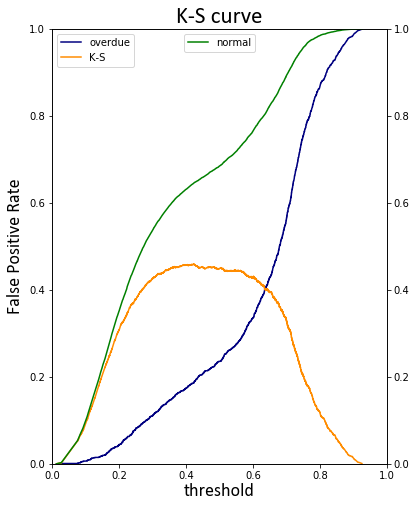

In [33]:
ks_curve(y_tr_test,y_predict_proba2[:,1])

# 交叉验证  
&ensp;&ensp;以上过程是建立在一次性二八分，用八份去通过GridSearchCV+hyperopt得到最佳超参数，然后在此超参数下对这八份进行学习得到最佳模型，然后用最佳模型对那二份进行预测并计算AUC和KS。  
&ensp;&ensp;一次性二八分会否太单一？我认为可以在此超参数下使用交叉验证，多算几个验证分数。也就是把整个训练集X_tr, y_tr进行五折划分，在此超参数下学得5个模型，这5个模型对各自的验证集进行预测，得到5个auc和ks评分。可以看看这5个评分，算一下均分。

In [34]:
# 本来准备使用 sklearn cross_val_score 进行交叉验证，但是运行太慢。代码如下：
# modelXGB2 = XGBClassifier(**XGB_param8)  # XGB_param8是最佳超参数+固定参数
# scores2 = cross_val_score(modelXGB2, X_tr, y_tr,cv = 5, scoring="roc_auc")  # 或试试cv=10
# print("5Fold scores :", scores2)
# print("5Fold mean score :", np.mean(scores2))


# 准备手动交叉验证。

In [35]:
# 对训练集 X_tr，y_tr进行一次性五折划分。
# Xta 存储了 5个二维array，分别是5份训练集。     # a 表示 all，完整训练集
# Xva 存储了 5个二维array，分别是对应的5份验证集。
# Yta 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yva 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=9)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xta = []
Yta = []
Xva = []
Yva = []
for train_index, validation_index in skf.split(X_tr.values,y_tr.values):  
    Xta.append(X_tr.values[train_index])
    Yta.append(y_tr.values[train_index])
    Xva.append(X_tr.values[validation_index])
    Yva.append(y_tr.values[validation_index])

In [36]:
# 参数使用 最佳超参数 XGB_param8 。

In [37]:
# 对训练集的五折划分，每一折都训练一个XGB模型，每个模型分别对自己的训练集和验证集进行预测并计算 auc。
# Models2 保存了 5 个模型。 Scores2 保存了 5 个模型分别对各自的验证集进行预测算得的 auc。
# 并求 5 个验证集 auc 值 的均值。


timestart = time.time()
Scores2=[]
Models2=[XGBClassifier(**XGB_param4) for i in range(len(Xta))]  # 创建 5 个模型
for i in range(len(Xta)):
    Models2[i].fit(Xta[i],Yta[i], eval_set = [(Xta[i],Yta[i]),( Xva[i],Yva[i])],
                   eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
    Scores2.append(Models2[i].best_score)
    print("-------------------------------")
print("Time: {:.2f} seconds".format(time.time() - timestart))
print("Scores1 : ", Scores2)
print("The mean auc is :", np.mean(Scores2))

# 我之前是这样做的：Models2=[]，然后在for循环里 modelXGB2.fit数据集，再 Models2.append(modelXGB2)
# 但发现这样做，得到的 Models2 里的五个模型全相同，都是最终的模型。所以我认为，应该在每一轮创建新的模型，
# 而不是同一个模型 modelXGB2 反复 fit 不同的数据。所以上述代码是在每一轮创建新模型。

[0]	validation_0-logloss:0.672959	validation_0-auc:0.745113	validation_1-logloss:0.672999	validation_1-auc:0.738649
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.65664	validation_0-auc:0.753534	validation_1-logloss:0.656543	validation_1-auc:0.748906
[2]	validation_0-logloss:0.643331	validation_0-auc:0.754762	validation_1-logloss:0.643482	validation_1-auc:0.748737
[3]	validation_0-logloss:0.632317	validation_0-auc:0.762496	validation_1-logloss:0.632697	validation_1-auc:0.751611
[4]	validation_0-logloss:0.623051	validation_0-auc:0.769235	validation_1-logloss:0.62381	validation_1-auc:0.757578
[5]	validation_0-logloss:0.615496	validation_0-auc:0.769394	validation_1-logloss:0.616312	validation_1-auc:0.757204
[6]	validation_0-logloss:0.608978	validation_0-auc:0.770709	validation_1-logloss:0.610016	validation_1-auc:0.7585
[7]	validation_0-logloss:0.60355	va

[70]	validation_0-logloss:0.537295	validation_0-auc:0.817821	validation_1-logloss:0.546679	validation_1-auc:0.791888
[71]	validation_0-logloss:0.536669	validation_0-auc:0.818328	validation_1-logloss:0.546094	validation_1-auc:0.792397
[72]	validation_0-logloss:0.536143	validation_0-auc:0.818897	validation_1-logloss:0.545614	validation_1-auc:0.7927
[73]	validation_0-logloss:0.535852	validation_0-auc:0.819206	validation_1-logloss:0.545452	validation_1-auc:0.79278
[74]	validation_0-logloss:0.535444	validation_0-auc:0.819652	validation_1-logloss:0.545166	validation_1-auc:0.792908
[75]	validation_0-logloss:0.535049	validation_0-auc:0.820152	validation_1-logloss:0.544955	validation_1-auc:0.793098
[76]	validation_0-logloss:0.53446	validation_0-auc:0.8206	validation_1-logloss:0.544445	validation_1-auc:0.793577
[77]	validation_0-logloss:0.534109	validation_0-auc:0.820883	validation_1-logloss:0.544187	validation_1-auc:0.79367
[78]	validation_0-logloss:0.533401	validation_0-auc:0.821302	validation

[141]	validation_0-logloss:0.511974	validation_0-auc:0.840351	validation_1-logloss:0.530135	validation_1-auc:0.797626
[142]	validation_0-logloss:0.511751	validation_0-auc:0.840581	validation_1-logloss:0.530076	validation_1-auc:0.797541
[143]	validation_0-logloss:0.511466	validation_0-auc:0.840787	validation_1-logloss:0.529982	validation_1-auc:0.797347
[144]	validation_0-logloss:0.511266	validation_0-auc:0.840997	validation_1-logloss:0.529912	validation_1-auc:0.797287
[145]	validation_0-logloss:0.510966	validation_0-auc:0.841196	validation_1-logloss:0.529721	validation_1-auc:0.797366
[146]	validation_0-logloss:0.510698	validation_0-auc:0.841454	validation_1-logloss:0.529551	validation_1-auc:0.797461
[147]	validation_0-logloss:0.510402	validation_0-auc:0.84174	validation_1-logloss:0.529372	validation_1-auc:0.797471
[148]	validation_0-logloss:0.51009	validation_0-auc:0.842107	validation_1-logloss:0.52929	validation_1-auc:0.797333
[149]	validation_0-logloss:0.509759	validation_0-auc:0.8423

[57]	validation_0-logloss:0.543043	validation_0-auc:0.812112	validation_1-logloss:0.554688	validation_1-auc:0.780964
[58]	validation_0-logloss:0.542741	validation_0-auc:0.812396	validation_1-logloss:0.554459	validation_1-auc:0.781135
[59]	validation_0-logloss:0.542283	validation_0-auc:0.812738	validation_1-logloss:0.554138	validation_1-auc:0.781419
[60]	validation_0-logloss:0.541286	validation_0-auc:0.813634	validation_1-logloss:0.553171	validation_1-auc:0.782411
[61]	validation_0-logloss:0.540938	validation_0-auc:0.813974	validation_1-logloss:0.552948	validation_1-auc:0.782597
[62]	validation_0-logloss:0.540607	validation_0-auc:0.814266	validation_1-logloss:0.552716	validation_1-auc:0.782453
[63]	validation_0-logloss:0.539921	validation_0-auc:0.814911	validation_1-logloss:0.552162	validation_1-auc:0.78292
[64]	validation_0-logloss:0.53945	validation_0-auc:0.815302	validation_1-logloss:0.551981	validation_1-auc:0.782759
[65]	validation_0-logloss:0.538957	validation_0-auc:0.8159	validat

[41]	validation_0-logloss:0.553967	validation_0-auc:0.800529	validation_1-logloss:0.559002	validation_1-auc:0.780874
[42]	validation_0-logloss:0.553323	validation_0-auc:0.801223	validation_1-logloss:0.558521	validation_1-auc:0.781162
[43]	validation_0-logloss:0.552444	validation_0-auc:0.802064	validation_1-logloss:0.557805	validation_1-auc:0.781912
[44]	validation_0-logloss:0.552023	validation_0-auc:0.802605	validation_1-logloss:0.557465	validation_1-auc:0.782305
[45]	validation_0-logloss:0.551393	validation_0-auc:0.803496	validation_1-logloss:0.556849	validation_1-auc:0.78283
[46]	validation_0-logloss:0.550746	validation_0-auc:0.803912	validation_1-logloss:0.556144	validation_1-auc:0.783322
[47]	validation_0-logloss:0.549746	validation_0-auc:0.804807	validation_1-logloss:0.555288	validation_1-auc:0.784172
[48]	validation_0-logloss:0.549136	validation_0-auc:0.805273	validation_1-logloss:0.554969	validation_1-auc:0.784091
[49]	validation_0-logloss:0.548573	validation_0-auc:0.805726	vali

[112]	validation_0-logloss:0.520086	validation_0-auc:0.832655	validation_1-logloss:0.536182	validation_1-auc:0.791214
[113]	validation_0-logloss:0.51979	validation_0-auc:0.832884	validation_1-logloss:0.536013	validation_1-auc:0.791177
[114]	validation_0-logloss:0.519493	validation_0-auc:0.832926	validation_1-logloss:0.535803	validation_1-auc:0.791221
[115]	validation_0-logloss:0.519241	validation_0-auc:0.833129	validation_1-logloss:0.535635	validation_1-auc:0.791291
Stopping. Best iteration:
[105]	validation_0-logloss:0.52272	validation_0-auc:0.830249	validation_1-logloss:0.537495	validation_1-auc:0.791296

-------------------------------
[0]	validation_0-logloss:0.673606	validation_0-auc:0.748897	validation_1-logloss:0.673859	validation_1-auc:0.755477
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.657763	validation_0-auc:0.754612	validation_1-logloss

[64]	validation_0-logloss:0.543542	validation_0-auc:0.811316	validation_1-logloss:0.5521	validation_1-auc:0.803639
[65]	validation_0-logloss:0.542922	validation_0-auc:0.811837	validation_1-logloss:0.55158	validation_1-auc:0.803993
[66]	validation_0-logloss:0.542625	validation_0-auc:0.812038	validation_1-logloss:0.551423	validation_1-auc:0.80399
[67]	validation_0-logloss:0.542264	validation_0-auc:0.812331	validation_1-logloss:0.55117	validation_1-auc:0.804026
[68]	validation_0-logloss:0.541972	validation_0-auc:0.812623	validation_1-logloss:0.550994	validation_1-auc:0.804056
[69]	validation_0-logloss:0.541531	validation_0-auc:0.813185	validation_1-logloss:0.550551	validation_1-auc:0.804706
[70]	validation_0-logloss:0.540942	validation_0-auc:0.813589	validation_1-logloss:0.550031	validation_1-auc:0.805143
[71]	validation_0-logloss:0.540621	validation_0-auc:0.813881	validation_1-logloss:0.549741	validation_1-auc:0.805409
[72]	validation_0-logloss:0.540126	validation_0-auc:0.814251	validati

[134]	validation_0-logloss:0.517499	validation_0-auc:0.83565	validation_1-logloss:0.533323	validation_1-auc:0.813314
[135]	validation_0-logloss:0.517192	validation_0-auc:0.836033	validation_1-logloss:0.533029	validation_1-auc:0.81357
[136]	validation_0-logloss:0.516736	validation_0-auc:0.83641	validation_1-logloss:0.532681	validation_1-auc:0.813624
[137]	validation_0-logloss:0.516411	validation_0-auc:0.836684	validation_1-logloss:0.532475	validation_1-auc:0.813578
[138]	validation_0-logloss:0.516035	validation_0-auc:0.837001	validation_1-logloss:0.532146	validation_1-auc:0.813682
[139]	validation_0-logloss:0.515734	validation_0-auc:0.83724	validation_1-logloss:0.53196	validation_1-auc:0.813689
[140]	validation_0-logloss:0.515531	validation_0-auc:0.837429	validation_1-logloss:0.531891	validation_1-auc:0.813628
[141]	validation_0-logloss:0.515299	validation_0-auc:0.83765	validation_1-logloss:0.531804	validation_1-auc:0.813459
[142]	validation_0-logloss:0.515016	validation_0-auc:0.837845	

[52]	validation_0-logloss:0.548775	validation_0-auc:0.807394	validation_1-logloss:0.552989	validation_1-auc:0.792023
[53]	validation_0-logloss:0.548134	validation_0-auc:0.807907	validation_1-logloss:0.552339	validation_1-auc:0.792398
[54]	validation_0-logloss:0.547451	validation_0-auc:0.808429	validation_1-logloss:0.551673	validation_1-auc:0.792889
[55]	validation_0-logloss:0.546878	validation_0-auc:0.809006	validation_1-logloss:0.551221	validation_1-auc:0.793365
[56]	validation_0-logloss:0.546438	validation_0-auc:0.809368	validation_1-logloss:0.550827	validation_1-auc:0.793552
[57]	validation_0-logloss:0.546129	validation_0-auc:0.809567	validation_1-logloss:0.550655	validation_1-auc:0.793446
[58]	validation_0-logloss:0.545731	validation_0-auc:0.810024	validation_1-logloss:0.550438	validation_1-auc:0.793602
[59]	validation_0-logloss:0.545319	validation_0-auc:0.810361	validation_1-logloss:0.550206	validation_1-auc:0.793517
[60]	validation_0-logloss:0.54491	validation_0-auc:0.81085	valid

In [38]:
Models2

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=6.7441006816990035, seed=1,
        silent=True, subsample=1.0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
        max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
        n_estimators=1000, n_jobs=1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=6.7441006816990035, seed=1,
        silent=True, subsample=1.0),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=1,
        colsample_bylevel=1, colsample_bytree=1, gamma

In [39]:
# 将五折训练出的 五个模型 的具体情况 做成表。
# model_round 是第几个模型，一共 5 个模型，按计算顺序排列。best_iteration 给出了训练此模型时的最佳轮数
# （因为设置了 early stopping）。
# train_auc 是此模型对其训练集进行预测计算出的 auc 值，validation_auc 是此模型对其验证集进行预测计算出的 auc 值。

roundXGB2=[]  
train_auc2=[]  
validation_auc2=[]  
best_iteration2=[]

for i in range(len(Scores2)):
    
    # round 表是 五折中的第几个模型。一共 5 个模型。
    roundXGB2.append(i+1)
    
    # 找出第 i个模型的最佳轮模型在自己训练集上预测时计算得到的auc值。
    train_auc2.append(Models2[i].evals_result()["validation_0"]["auc"][ Models2[i].best_iteration])
    
    # 找出第i个模型的最佳轮模型在自己验证集上预测时计算得到的auc值。
    validation_auc2.append(Models2[i].evals_result()["validation_1"]["auc"][ Models2[i].best_iteration])
    
    # i个模型的最佳轮是第几轮
    best_iteration2.append(Models2[i].best_iteration)

d = {"model_round":roundXGB2, "train_auc": train_auc2 , "validation_auc": validation_auc2 , "best_iteration": best_iteration2 }
auc_result2 = pd.DataFrame(d,index=[1,2,3,4,5])


In [40]:
# 验证集 auc 在 0.796 左右。

auc_result2 

,best_iteration,model_round,train_auc,validation_auc
1,141,1,0.840351,0.797626
2,73,2,0.819393,0.783883
3,105,3,0.830249,0.791296
4,139,4,0.837240,0.813689
5,104,5,0.828633,0.797220


In [41]:
np.mean(auc_result2["validation_auc"])

0.7967428

# 训练最终XGB模型并预测未知样本集

In [42]:
# 训练最终XGB模型并预测未知样本集

modelXGB4 = XGBClassifier(**XGB_param4)  # XGB_param4是最佳超参数+固定参数
modelXGB4.fit(X_tr, y_tr)
proba_prediction4 = modelXGB4.predict_proba(X_te)

In [43]:
# 将预测结果整合成表

XGBpre = pd.DataFrame(proba_prediction4[:,1],index=X_te.index,columns=["positive_proba"]).reset_index()
XGBpre.columns = ["userid","probability"]  # 按官网提交示例修改列名

In [44]:
XGBpre

,userid,probability
0,55597,0.745781
1,55598,0.015785
2,55599,0.185283
3,55600,0.446304
4,55601,0.588982
5,55602,0.337631
6,55603,0.423635
7,55604,0.131063
8,55605,0.416786
9,55606,0.095160


In [45]:
# 保存预测结果

XGBpre.to_csv(r'F:\RiskPre2\result\XGBpre.csv',index=False)

In [46]:
# 保存模型

joblib.dump(modelXGB4, r'F:\RiskPre2\result\modelXGB5.pkl')

['F:\\RiskPre2\\result\\modelXGB5.pkl']

# 提交结果

In [47]:
# 提交 XGBpre 结果：计算的 ks 值是： 0.38***9 。